<b>Conversational AI Assignment 2

Hybrid RAG System with Automated Evaluation




####**Group ID: 54**</b>

BITS Students details:

Group Members Name with Student ID:


Name ID Contribution
<pre>
VAIBHAV SAREEN	          2024AA05923	        100 %
LAWLESH KUMAR	          2024AA05149	        100 %
VIVEK TRIVEDI	          2024AA05922	        100 %
NITESH KUMAR	          2024AA05143	        100 %
LOGESH M	          2024AA05163	        100 %
</pre>

**Objective**

Build a Hybrid Retrieval-Augmented Generation (RAG) system combining dense vector retrieval, sparse keyword retrieval (BM25), and Reciprocal Rank Fusion (RRF) to answer questions from 500 Wikipedia articles. Evaluate using an automated framework with 100 generated questions.

**Dataset Requirements**

Wikipedia URL Collection (500 URLs per group):

Fixed Set (200 URLs): Each group must first sample a unique set of 200 Wikipedia URLs (minimum 200 words per page) covering diverse topics. Store these in a JSON file (fixed_urls.json). No two groups should share the same 200 URLs. These URLs remain constant across all indexing operations.


Random Set (300 URLs): For each indexing run, randomly sample 300 additional Wikipedia URLs (minimum 200 words per page). These should change every time the system is rebuilt/indexed.


Total Corpus: 200 fixed + 300 random = 500 URLs. Extract, clean, and chunk the text (200-400 tokens with 50-token overlap). Store with metadata (URL, title, unique chunk IDs).

**Part 1: Hybrid RAG System (10 Marks)**

**1.1 Dense Vector Retrieval**

Use a sentence embedding model (e.g., all-MiniLM-L6-v2, all-mpnet-base-v2) to embed chunks. Build a vector index (FAISS/ChromaDB) and retrieve top-K chunks via cosine similarity.

**1.2 Sparse Keyword Retrieval**

Implement BM25 algorithm for keyword-based retrieval. Build index over chunks and retrieve top-K results.

**1.3 Reciprocal Rank Fusion (RRF)**

For each query, retrieve top-K chunks from both dense and sparse methods. Combine using RRF: RRF_score(d) = Σ 1/(k + rank_i(d)) where k=60. Select top-N chunks by RRF score for final context.

**1.4 Response Generation**

Use an open-source LLM (e.g., DistilGPT2, Flan-T5-base, Llama-2-7B). Concatenate top-N chunks with query and generate answers within context limits.

**1.5 User Interface**

Build with Streamlit/Gradio/Flask. Display: user query input, generated answer, top retrieved chunks with sources, dense/sparse/RRF scores, and response time.

<b>Hybrid RAG Syatem </b>

<b>  </b>

<b>Install Dependencies</b>

In [ ]:
!pip install wikipedia-api beautifulsoup4
!pip install sentence-transformers faiss-cpu
!pip install rank-bm25 nltk
!pip install transformers torch
!pip install tqdm
!pip install faiss-cpu

<b>Imports & NLTK Setup</b>

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import json
import random
import time
import uuid
import re
from collections import defaultdict

import wikipediaapi
from bs4 import BeautifulSoup

import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")
nltk.download("punkt_tab")

import numpy as np
import faiss
from rank_bm25 import BM25Okapi

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

from tqdm import tqdm


[nltk_data] Downloading package punkt to
[nltk_data]     /home/niteshkumar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/niteshkumar/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


<b> Configuration for corpus size  </b>

In [2]:

FIXED_URL_COUNT = 200
RANDOM_URL_COUNT = 300
TOTAL_CORPUS_SIZE = FIXED_URL_COUNT + RANDOM_URL_COUNT

EVAL_QUESTION_COUNT = 100

"""

FIXED_URL_COUNT = 10
RANDOM_URL_COUNT = 20
TOTAL_CORPUS_SIZE = FIXED_URL_COUNT + RANDOM_URL_COUNT

EVAL_QUESTION_COUNT = 10
"""

'\n\nFIXED_URL_COUNT = 10\nRANDOM_URL_COUNT = 20\nTOTAL_CORPUS_SIZE = FIXED_URL_COUNT + RANDOM_URL_COUNT\n\nEVAL_QUESTION_COUNT = 10\n'

<b> Create fixed_urls.json  </b>

In [3]:
import json
# Replace URLs with your group’s unique 200 URLs

fixed_urls = [
    "https://en.wikipedia.org/wiki/Artificial_intelligence",
    "https://en.wikipedia.org/wiki/Machine_learning",
    "https://en.wikipedia.org/wiki/Deep_learning",
    "https://en.wikipedia.org/wiki/Neural_network",
    "https://en.wikipedia.org/wiki/Natural_language_processing",
    "https://en.wikipedia.org/wiki/Computer_vision",
    "https://en.wikipedia.org/wiki/Reinforcement_learning",
    "https://en.wikipedia.org/wiki/Genetic_algorithm",
    "https://en.wikipedia.org/wiki/Expert_system",
    "https://en.wikipedia.org/wiki/Knowledge_representation",
    "https://en.wikipedia.org/wiki/Data_mining",
    "https://en.wikipedia.org/wiki/Big_data",
    "https://en.wikipedia.org/wiki/Pattern_recognition",
    "https://en.wikipedia.org/wiki/Information_retrieval",
    "https://en.wikipedia.org/wiki/Semantic_web",
    "https://en.wikipedia.org/wiki/Robotics",
    "https://en.wikipedia.org/wiki/Autonomous_robot",
    "https://en.wikipedia.org/wiki/Computer_science",
    "https://en.wikipedia.org/wiki/Algorithm",
    "https://en.wikipedia.org/wiki/Computational_complexity_theory",

    "https://en.wikipedia.org/wiki/Quantum_computing",
    "https://en.wikipedia.org/wiki/Operating_system",
    "https://en.wikipedia.org/wiki/Distributed_computing",
    "https://en.wikipedia.org/wiki/Cloud_computing",
    "https://en.wikipedia.org/wiki/Internet_of_things",
    "https://en.wikipedia.org/wiki/Cybersecurity",
    "https://en.wikipedia.org/wiki/Cryptography",
    "https://en.wikipedia.org/wiki/Blockchain",
    "https://en.wikipedia.org/wiki/Computer_network",
    "https://en.wikipedia.org/wiki/Database",
    "https://en.wikipedia.org/wiki/Software_engineering",
    "https://en.wikipedia.org/wiki/Programming_language",
    "https://en.wikipedia.org/wiki/Compiler",
    "https://en.wikipedia.org/wiki/Computer_architecture",
    "https://en.wikipedia.org/wiki/Embedded_system",
    "https://en.wikipedia.org/wiki/Human%E2%80%93computer_interaction",
    "https://en.wikipedia.org/wiki/Information_security",
    "https://en.wikipedia.org/wiki/Digital_signal_processing",
    "https://en.wikipedia.org/wiki/Image_processing",
    "https://en.wikipedia.org/wiki/Parallel_computing",

    "https://en.wikipedia.org/wiki/World_War_I",
    "https://en.wikipedia.org/wiki/World_War_II",
    "https://en.wikipedia.org/wiki/French_Revolution",
    "https://en.wikipedia.org/wiki/Industrial_Revolution",
    "https://en.wikipedia.org/wiki/Renaissance",
    "https://en.wikipedia.org/wiki/Cold_War",
    "https://en.wikipedia.org/wiki/Russian_Revolution",
    "https://en.wikipedia.org/wiki/American_Civil_War",
    "https://en.wikipedia.org/wiki/Ancient_Egypt",
    "https://en.wikipedia.org/wiki/Roman_Empire",
    "https://en.wikipedia.org/wiki/History_of_India",
    "https://en.wikipedia.org/wiki/Mughal_Empire",
    "https://en.wikipedia.org/wiki/British_Empire",
    "https://en.wikipedia.org/wiki/History_of_China",
    "https://en.wikipedia.org/wiki/History_of_Europe",
    "https://en.wikipedia.org/wiki/Feudalism",
    "https://en.wikipedia.org/wiki/Colonialism",
    "https://en.wikipedia.org/wiki/Imperialism",
    "https://en.wikipedia.org/wiki/Nationalism",
    "https://en.wikipedia.org/wiki/Global_conflict",

    "https://en.wikipedia.org/wiki/Indian_Constitution",
    "https://en.wikipedia.org/wiki/United_States_Constitution",
    "https://en.wikipedia.org/wiki/International_law",
    "https://en.wikipedia.org/wiki/Criminal_law",
    "https://en.wikipedia.org/wiki/Civil_law_(legal_system)",
    "https://en.wikipedia.org/wiki/Human_rights",
    "https://en.wikipedia.org/wiki/Intellectual_property",
    "https://en.wikipedia.org/wiki/Contract_law",
    "https://en.wikipedia.org/wiki/Tort_law",
    "https://en.wikipedia.org/wiki/Administrative_law",
    "https://en.wikipedia.org/wiki/Constitutional_law",
    "https://en.wikipedia.org/wiki/Legal_system",
    "https://en.wikipedia.org/wiki/Judiciary",
    "https://en.wikipedia.org/wiki/Rule_of_law",
    "https://en.wikipedia.org/wiki/Legal_history",
    "https://en.wikipedia.org/wiki/International_humanitarian_law",
    "https://en.wikipedia.org/wiki/Comparative_law",
    "https://en.wikipedia.org/wiki/Statutory_law",
    "https://en.wikipedia.org/wiki/Common_law",
    "https://en.wikipedia.org/wiki/Civil_procedure",

    "https://en.wikipedia.org/wiki/Economics",
    "https://en.wikipedia.org/wiki/Microeconomics",
    "https://en.wikipedia.org/wiki/Macroeconomics",
    "https://en.wikipedia.org/wiki/Inflation",
    "https://en.wikipedia.org/wiki/Unemployment",
    "https://en.wikipedia.org/wiki/Monetary_policy",
    "https://en.wikipedia.org/wiki/Fiscal_policy",
    "https://en.wikipedia.org/wiki/International_trade",
    "https://en.wikipedia.org/wiki/Globalization",
    "https://en.wikipedia.org/wiki/Behavioral_economics",
    "https://en.wikipedia.org/wiki/Development_economics",
    "https://en.wikipedia.org/wiki/Public_finance",
    "https://en.wikipedia.org/wiki/Economic_growth",
    "https://en.wikipedia.org/wiki/Market_economy",
    "https://en.wikipedia.org/wiki/Capitalism",
    "https://en.wikipedia.org/wiki/Socialism",
    "https://en.wikipedia.org/wiki/Mixed_economy",
    "https://en.wikipedia.org/wiki/Game_theory",
    "https://en.wikipedia.org/wiki/Labor_economics",
    "https://en.wikipedia.org/wiki/Financial_market",

    "https://en.wikipedia.org/wiki/Physics",
    "https://en.wikipedia.org/wiki/Classical_mechanics",
    "https://en.wikipedia.org/wiki/Quantum_mechanics",
    "https://en.wikipedia.org/wiki/Thermodynamics",
    "https://en.wikipedia.org/wiki/Electromagnetism",
    "https://en.wikipedia.org/wiki/Relativity",
    "https://en.wikipedia.org/wiki/Astrophysics",
    "https://en.wikipedia.org/wiki/Particle_physics",
    "https://en.wikipedia.org/wiki/Nuclear_physics",
    "https://en.wikipedia.org/wiki/Optics",
    "https://en.wikipedia.org/wiki/Chemistry",
    "https://en.wikipedia.org/wiki/Organic_chemistry",
    "https://en.wikipedia.org/wiki/Inorganic_chemistry",
    "https://en.wikipedia.org/wiki/Physical_chemistry",
    "https://en.wikipedia.org/wiki/Biochemistry",
    "https://en.wikipedia.org/wiki/Periodic_table",
    "https://en.wikipedia.org/wiki/Chemical_bond",
    "https://en.wikipedia.org/wiki/Catalysis",
    "https://en.wikipedia.org/wiki/Polymer",
    "https://en.wikipedia.org/wiki/Reaction_rate",

    "https://en.wikipedia.org/wiki/Biology",
    "https://en.wikipedia.org/wiki/Genetics",
    "https://en.wikipedia.org/wiki/Evolution",
    "https://en.wikipedia.org/wiki/Cell_biology",
    "https://en.wikipedia.org/wiki/Molecular_biology",
    "https://en.wikipedia.org/wiki/Ecology",
    "https://en.wikipedia.org/wiki/Neuroscience",
    "https://en.wikipedia.org/wiki/Immunology",
    "https://en.wikipedia.org/wiki/Microbiology",
    "https://en.wikipedia.org/wiki/Biotechnology",
    "https://en.wikipedia.org/wiki/Medicine",
    "https://en.wikipedia.org/wiki/Public_health",
    "https://en.wikipedia.org/wiki/Epidemiology",
    "https://en.wikipedia.org/wiki/Cardiology",
    "https://en.wikipedia.org/wiki/Neurology",
    "https://en.wikipedia.org/wiki/Oncology",
    "https://en.wikipedia.org/wiki/Pediatrics",
    "https://en.wikipedia.org/wiki/Psychiatry",
    "https://en.wikipedia.org/wiki/Pharmacology",
    "https://en.wikipedia.org/wiki/Surgery",

    "https://en.wikipedia.org/wiki/Climate_change",
    "https://en.wikipedia.org/wiki/Global_warming",
    "https://en.wikipedia.org/wiki/Renewable_energy",
    "https://en.wikipedia.org/wiki/Solar_energy",
    "https://en.wikipedia.org/wiki/Wind_power",
    "https://en.wikipedia.org/wiki/Hydroelectricity",
    "https://en.wikipedia.org/wiki/Nuclear_power",
    "https://en.wikipedia.org/wiki/Sustainable_development",
    "https://en.wikipedia.org/wiki/Environmental_science",
    "https://en.wikipedia.org/wiki/Biodiversity",
    "https://en.wikipedia.org/wiki/Geography",
    "https://en.wikipedia.org/wiki/Physical_geography",
    "https://en.wikipedia.org/wiki/Human_geography",
    "https://en.wikipedia.org/wiki/Geology",
    "https://en.wikipedia.org/wiki/Plate_tectonics",
    "https://en.wikipedia.org/wiki/Volcano",
    "https://en.wikipedia.org/wiki/Earthquake",
    "https://en.wikipedia.org/wiki/Meteorology",
    "https://en.wikipedia.org/wiki/Oceanography",
    "https://en.wikipedia.org/wiki/Cartography",

    "https://en.wikipedia.org/wiki/Federated_learning",
    "https://en.wikipedia.org/wiki/Self-supervised_learning",
    "https://en.wikipedia.org/wiki/Zero-shot_learning",
    "https://en.wikipedia.org/wiki/Few-shot_learning",
    "https://en.wikipedia.org/wiki/Knowledge_graph",
    "https://en.wikipedia.org/wiki/Search_engine",
    "https://en.wikipedia.org/wiki/Information_extraction",
    "https://en.wikipedia.org/wiki/Question_answering",
    "https://en.wikipedia.org/wiki/Text_mining",
    "https://en.wikipedia.org/wiki/Sentiment_analysis",
    "https://en.wikipedia.org/wiki/History_of_computing",
    "https://en.wikipedia.org/wiki/Computer_program",
    "https://en.wikipedia.org/wiki/Debugging",
    "https://en.wikipedia.org/wiki/Software_testing",
    "https://en.wikipedia.org/wiki/Agile_software_development",
    "https://en.wikipedia.org/wiki/Philosophy_of_artificial_intelligence",
    "https://en.wikipedia.org/wiki/Artificial_general_intelligence",
    "https://en.wikipedia.org/wiki/Machine_ethics",
    "https://en.wikipedia.org/wiki/Automation",
    "https://en.wikipedia.org/wiki/Control_system",

    "https://en.wikipedia.org/wiki/Political_economy",
    "https://en.wikipedia.org/wiki/Welfare_state",
    "https://en.wikipedia.org/wiki/Public_policy",
    "https://en.wikipedia.org/wiki/Regulation",
    "https://en.wikipedia.org/wiki/Corporate_governance",
    "https://en.wikipedia.org/wiki/International_organization",
    "https://en.wikipedia.org/wiki/Non-governmental_organization",
    "https://en.wikipedia.org/wiki/United_Nations_Development_Programme",
    "https://en.wikipedia.org/wiki/World_Bank",
    "https://en.wikipedia.org/wiki/International_Labour_Organization",
    "https://en.wikipedia.org/wiki/Energy_economics",
    "https://en.wikipedia.org/wiki/Climate_policy",
    "https://en.wikipedia.org/wiki/Carbon_tax",
    "https://en.wikipedia.org/wiki/Emission_trading",
    "https://en.wikipedia.org/wiki/Circular_economy",
    "https://en.wikipedia.org/wiki/History_of_technology",
    "https://en.wikipedia.org/wiki/Industrial_design",
    "https://en.wikipedia.org/wiki/Innovation",
    "https://en.wikipedia.org/wiki/Technological_change",
    "https://en.wikipedia.org/wiki/Science_and_technology_studies"
]

subset_fixed_urls = fixed_urls[:FIXED_URL_COUNT]

with open("fixed_urls.json", "w") as f:
    json.dump(subset_fixed_urls, f, indent=2)

print(f"fixed_urls.json created with {len(subset_fixed_urls)} URLs")

print("\nLast 3 entries:")
for url in subset_fixed_urls[-3:]:
    print(f" - {url}")

fixed_urls.json created with 200 URLs

Last 3 entries:
 - https://en.wikipedia.org/wiki/Innovation
 - https://en.wikipedia.org/wiki/Technological_change
 - https://en.wikipedia.org/wiki/Science_and_technology_studies


<b>Wikipedia Download & Cleaning</b>

In [4]:
import wikipediaapi

wiki = wikipediaapi.Wikipedia(
    language="en",
    user_agent="HybridRAG-Project/1.0 (academic-use-only)",
    extract_format=wikipediaapi.ExtractFormat.HTML
)

def clean_text(html_text):
    soup = BeautifulSoup(html_text, "html.parser")
    for tag in soup(["sup", "table"]):
        tag.decompose()
    text = soup.get_text(separator=" ")
    text = re.sub(r"\s+", " ", text)
    return text.strip()

<b>Chunking (200–400 tokens, 50 overlap)</b>

In [5]:
def chunk_text(text, min_tokens=200, max_tokens=400, overlap=50):
    tokens = word_tokenize(text)
    chunks = []
    start = 0
    while start < len(tokens):
        end = min(start + max_tokens, len(tokens))
        if end - start < min_tokens and chunks:
            break
        chunk = tokens[start:end]
        chunks.append(" ".join(chunk))
        start = end - overlap
    return chunks

<b> Load Fixed URLs & Sample Random URLs </b>

In [6]:
import requests
import urllib.parse

def sample_random_urls(n=300, batch_size=10, max_retries=5):
    urls = set()
    headers = {"User-Agent": "HybridRAG-Project-Group45/1.0 (academic-use-only)"}

    pbar = tqdm(total=n, desc="Sampling Random URLs")

    while len(urls) < n:
        retry_count = 0
        success = False

        while retry_count < max_retries and not success:
            try:
                response = requests.get(
                    "https://en.wikipedia.org/w/api.php",
                    params={
                        "action": "query", "format": "json",
                        "list": "random", "rnnamespace": 0, "rnlimit": batch_size
                    },
                    headers=headers,
                    timeout=10 # Set timeout
                )

                # Check for HTTP 429 (Too Many Requests) or other errors
                if response.status_code == 429:
                    wait_time = 2 ** retry_count
                    time.sleep(wait_time)
                    retry_count += 1
                    continue

                data = response.json()
                success = True

                for item in data["query"]["random"]:
                    title = item["title"]
                    # Handle URL encoding for articles with special characters
                    safe_title = urllib.parse.quote(title.replace(" ", "_"))
                    full_url = f"https://en.wikipedia.org/wiki/{safe_title}"

                    page = wiki.page(title)
                    if page.exists() and len(page.text.split()) >= 200:
                        if full_url not in urls:
                            urls.add(full_url)
                            pbar.update(1)

                    if len(urls) >= n: break

            except (requests.exceptions.RequestException, ValueError) as e:
                # Catch connection errors and the "line 1 column 1" JSON error
                retry_count += 1
                wait_time = 2 ** retry_count
                time.sleep(wait_time)

        if not success:
            print(f"\nFailed to fetch batch after {max_retries} retries. Moving to next attempt.")

    pbar.close()
    return list(urls)

<b> Build Wikipedia Corpus (500 Articles)</b>

In [7]:
import urllib.parse

def build_corpus(fixed_urls, random_urls):
    all_chunks = []
    for url in tqdm(fixed_urls + random_urls, desc="Downloading & Chunking Articles from Wikipedia"):
        try:
            time.sleep(0.2)

            encoded_title = url.split("/")[-1]
            title = urllib.parse.unquote(encoded_title).replace("_", " ")
            page = wiki.page(title)
            if not page.exists(): continue

            text = clean_text(page.text)
            if len(text.split()) < 200: continue

            chunks = chunk_text(text)
            for c in chunks:
                all_chunks.append({
                    "chunk_id": str(uuid.uuid4()),
                    "title": page.title,
                    "url": page.fullurl,
                    "text": c
                })
        except Exception as e:
            print(f"Error processing {url}: {e}")
            continue
    return all_chunks

<b> Dense Retriever (FAISS + Sentence Transformers) </b>

In [8]:
class DenseRetriever:
    def __init__(self, chunks, model_name="all-MiniLM-L6-v2"):
        self.model = SentenceTransformer(model_name)
        self.metadata = chunks

        texts = [c["text"] for c in chunks]
        embeddings = self.model.encode(
            texts,
            convert_to_numpy=True,
            normalize_embeddings=True,
            show_progress_bar=True
        )

        vector_dimension = embeddings.shape[1]
        self.index = faiss.IndexFlatIP(vector_dimension)
        self.index.add(embeddings)

    def search(self, query, k=10):
        query_vector = self.model.encode(
            [query],
            convert_to_numpy=True,
            normalize_embeddings=True
        )

        scores, indices = self.index.search(query_vector, k)

        results = []
        for rank_idx, corpus_idx in enumerate(indices[0]):
            chunk_data = self.metadata[corpus_idx]

            result_item = {
                "chunk_id": chunk_data["chunk_id"],
                "rank": rank_idx + 1,
                "score": float(scores[0][rank_idx]),
                "meta": chunk_data
            }
            results.append(result_item)

        return results

<b> Sparse Retriever (BM25) </b>

In [9]:
class SparseRetriever:
    def __init__(self, chunks):
        self.metadata = chunks

        self.tokenized_corpus = [
            word_tokenize(c["text"].lower())
            for c in chunks
        ]

        self.bm25 = BM25Okapi(self.tokenized_corpus)

    def search(self, query, k=10):
        tokenized_query = word_tokenize(query.lower())
        scores = self.bm25.get_scores(tokenized_query)
        top_indices = np.argsort(scores)[::-1][:k]

        results = []
        for rank, idx in enumerate(top_indices):
            chunk_data = self.metadata[idx]

            result_item = {
                "chunk_id": chunk_data["chunk_id"],
                "rank": rank + 1,
                "score": float(scores[idx]),
                "meta": chunk_data
            }
            results.append(result_item)

        return results

<b> Reciprocal Rank Fusion (RRF)  </b>

In [10]:
# Reciprocal Rank Fusion

def rrf_fusion(dense_res, sparse_res, k=60):
    rrf_scores = defaultdict(float)

    individual_scores = defaultdict(lambda: {"dense": 0.0, "sparse": 0.0})
    metadata = {}

    for res in dense_res:
        rrf_scores[res["chunk_id"]] += 1 / (k + res["rank"])
        individual_scores[res["chunk_id"]]["dense"] = res["score"]
        metadata[res["chunk_id"]] = res["meta"]

    for res in sparse_res:
        rrf_scores[res["chunk_id"]] += 1 / (k + res["rank"])
        individual_scores[res["chunk_id"]]["sparse"] = res["score"]
        metadata[res["chunk_id"]] = res["meta"]

    ranked = sorted(rrf_scores.items(), key=lambda x: x[1], reverse=True)

    return [{
        "chunk_id": cid,
        "rrf_score": score,
        "dense_score": individual_scores[cid]["dense"],
        "sparse_score": individual_scores[cid]["sparse"],
        "meta": metadata[cid]
    } for cid, score in ranked]

<b>  Answer Generator (Flan-T5) </b>

In [11]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

class Generator:
    def __init__(self, model_name="google/flan-t5-base"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
        self.max_tokens = 512

    def generate(self, query, contexts):
        context_text = "\n\n".join(contexts)
        prompt = f"Answer using ONLY the context:\nContext: {context_text}\nQuestion: {query}\nAnswer:"
        inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=self.max_tokens)
        outputs = self.model.generate(**inputs, max_new_tokens=100)
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

<b>Full Hybrid RAG Pipeline</b>

In [12]:
class HybridRAG:
    def __init__(self, chunks):
        self.dense = DenseRetriever(chunks)
        self.sparse = SparseRetriever(chunks)
        self.generator = Generator()

    def answer(self, query, top_k=10, top_n=5):
        start = time.time()
        dense_res = self.dense.search(query, top_k)
        sparse_res = self.sparse.search(query, top_k)

        fused = rrf_fusion(dense_res, sparse_res)
        top_chunks = fused[:top_n]
        contexts = [c["meta"]["text"] for c in top_chunks]

        answer = self.generator.generate(query, contexts)

        return {
            "answer": answer,
            "contexts": top_chunks,
            "time": round(time.time() - start, 2)
        }

def process_query(query):
    res = rag_system.answer(query)

    table_data = []
    for i, c in enumerate(res["contexts"], 1):
        table_data.append([
            i,
            c["meta"]["title"],
            round(c.get("dense_score", 0), 4),
            round(c.get("sparse_score", 0), 4),
            round(c["rrf_score"], 4),
            c["meta"]["url"]
        ])

    return res["answer"], res["time"], table_data

<b>Build Index & Run Query (MAIN)</b>

In [13]:
import pandas as pd
from IPython.display import display

pd.set_option('display.max_colwidth', None)

with open("fixed_urls.json", "r") as f:
    fixed = json.load(f)

random_urls = sample_random_urls(n=RANDOM_URL_COUNT)

corpus_chunks = build_corpus(fixed, random_urls)

unique_urls = len(set(c['url'] for c in corpus_chunks))
if unique_urls == TOTAL_CORPUS_SIZE:
    print(f"Success: Corpus built with {unique_urls} unique articles.")
else:
    print(f"Warning: Corpus size mismatch. Expected {TOTAL_CORPUS_SIZE}, got {unique_urls}.")

print(f"Total Chunks Indexed: {len(corpus_chunks)}")

rag_system = HybridRAG(corpus_chunks)


test_query = "What is deep learning ?"
res = rag_system.answer(test_query)
print(f"\nQuery: {test_query}\nAnswer: {res['answer']}\nTime: {res['time']}s")

print("\nTop Retrieved Chunks:")
table_rows = []
for i, c in enumerate(res["contexts"], 1):
    table_rows.append({
        "Rank": i,
        "Title": c["meta"]["title"],
        "RRF Score": round(c["rrf_score"], 4),
        "Source": c["meta"]["url"]
    })

df_chunks = pd.DataFrame(table_rows)

styled_df = df_chunks.style.set_properties(**{
    'width': '600px',
    'text-align': 'left',
    'font-family': 'monospace'
}, subset=['Source']).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left'), ('background-color', '#f4f4f4')]}
])

display(styled_df)

Sampling Random URLs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [10:47<00:00,  2.16s/it]


Total Chunks Indexed: 4991


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/156 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/282 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning



Query: What is deep learning ?
Answer: Deep learning is a method of learning which uses layers to learn the features of the image .
Time: 1.6s

Top Retrieved Chunks:


,Rank,Title,RRF Score,Source
0,1,Deep learning,0.031700,https://en.wikipedia.org/wiki/Deep_learning
1,2,Artificial intelligence,0.031200,https://en.wikipedia.org/wiki/Artificial_intelligence
2,3,Artificial intelligence,0.030600,https://en.wikipedia.org/wiki/Artificial_intelligence
3,4,Deep learning,0.016400,https://en.wikipedia.org/wiki/Deep_learning
4,5,Deep learning,0.016400,https://en.wikipedia.org/wiki/Deep_learning


**Saves the preprocessed corpus (JSON) and the FAISS vector database (index file).**

In [14]:
import json
import faiss
import os

def dump_rag_assets(rag, corpus_chunks, folder_path="rag_assets"):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # 1. Dump Preprocessed Corpus (Metadata + Text)
    corpus_file = os.path.join(folder_path, "preprocessed_corpus.json")
    with open(corpus_file, "w") as f:
        json.dump(corpus_chunks, f, indent=2)
    print(f"Preprocessed corpus saved to: {corpus_file}")

    # 2. Dump Vector Database (FAISS Index)
    # The 'rag.dense.index' is the actual FAISS object
    index_file = os.path.join(folder_path, "vector_database.index")
    faiss.write_index(rag.dense.index, index_file)
    print(f"Vector database (FAISS) saved to: {index_file}")

dump_rag_assets(rag_system, corpus_chunks)

Preprocessed corpus saved to: rag_assets/preprocessed_corpus.json
Vector database (FAISS) saved to: rag_assets/vector_database.index


<b>  Test the System </b>

**1.5 User Interface**

Build with Gradio. Display: user query input, generated answer, top retrieved chunks with sources, dense/sparse/RRF scores, and response time.

In [17]:
import gradio as gr

try:
    demo.close()
except:
    pass

custom_css = """
.gradio-container { background-color: #f7f9fc; }
.main-header { text-align: center; color: #2d3436; margin-bottom: 20px; }
.stat-card { border-radius: 10px; padding: 15px; background: white; box-shadow: 0 4px 6px rgba(0,0,0,0.05); }
"""
def process_query(query):
    res = rag_system.answer(query)
    table_data = []

    for i, c in enumerate(res["contexts"], 1):
        table_data.append([
            i,
            c["meta"]["title"],
            round(c.get("dense_score", 0), 4),
            round(c.get("sparse_score", 0), 4),
            round(c["rrf_score"], 4),
            c["meta"]["url"]
        ])

    return res["answer"], res["time"], table_data

with gr.Blocks(theme=gr.themes.Soft(primary_hue="teal", secondary_hue="slate"), css=custom_css) as demo:

    gr.HTML("""
        <div class="main-header">
            <h1 style="font-weight: 800; font-size: 2.5rem; margin-bottom: 0;">🔍 Hybrid RAG Dashboard</h1>
            <p style="color: #636e72; font-size: 1.1rem;">Advanced Wikipedia Search with Dense & Sparse Rank Fusion</p>
        </div>
    """)

    with gr.Row():
        with gr.Column(scale=4):
            query_input = gr.Textbox(
                label="Enter your question",
                placeholder="Ask anything (e.g., How do neural networks learn?)",
                lines=1,
                container=True
            )
        with gr.Column(scale=1):
            submit_btn = gr.Button("Generate Answer", variant="primary")

    with gr.Row(equal_height=True):
        with gr.Column(scale=3):
            answer_output = gr.Textbox(
                label="Generated Answer",
                lines=6,
                interactive=False,
                # show_copy_button=True
            )
        with gr.Column(scale=1):
            time_output = gr.Label(label="Response Time", num_top_classes=0)
            gr.Markdown("**Pipeline Specs:**\n- Model: Flan-T5\n- Retrieval: Hybrid RRF")

    gr.Markdown("---")

    gr.Markdown("### 📑 Top Retrieved Chunks & Scores")
    sources_output = gr.Dataframe(
            headers=["Rank", "Title", "Dense Score", "Sparse Score", "RRF Score", "Source URL"],
            datatype=["number", "str", "number", "number", "number", "str"],
            interactive=False,
            column_widths=[60, 200, 100, 100, 100, 250]
    )

    gr.HTML("<p style='text-align: center; color: #b2bec3; margin-top: 50px;'>Hybrid RAG System | Group 45 Assignment</p>")

    submit_btn.click(
        fn=process_query,
        inputs=query_input,
        outputs=[answer_output, time_output, sources_output]
    )

demo.launch(share=True, inline=True)

/tmp/ipykernel_10833/1713398025.py:29: UserWarning: The parameters have been moved from the Blocks constructor to the launch() method in Gradio 6.0: theme, css. Please pass these parameters to launch() instead.
  with gr.Blocks(theme=gr.themes.Soft(primary_hue="teal", secondary_hue="slate"), css=custom_css) as demo:


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://6a9f07f4ac9385ae32.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


<b> PART 2 — AUTOMATED EVALUATION (COLAB NOTEBOOK) </b>

<b>
Imports
</b>

In [18]:
import json
import random
import time
from collections import defaultdict

import numpy as np
import pandas as pd
from tqdm import tqdm

<b> Question Generation (100 Q&A Pairs)<br>
Automated<br>
Stores ground truth, source URL, category </b>

In [19]:
import random
import json
import re
from tqdm import tqdm

def generate_diverse_questions(chunks, num_questions=EVAL_QUESTION_COUNT):
    questions = []
    qid = 0
    categories = ["factual", "comparative", "inferential", "multi-hop"]

    pbar = tqdm(total=num_questions, desc="Generating Evaluation Dataset")

    max_attempts = num_questions * 3
    attempts = 0

    print(f"\n{'='*50}")
    print(f"GENERATE MTarget {num_questions} Questions")
    print(f"{'='*50}")

    while len(questions) < num_questions and attempts < max_attempts:
        attempts += 1
        category = random.choice(categories)
        c1 = random.choice(chunks)

        # Keep context short to stay within 512 token limit
        context_snippet = c1['text'][:600]

        # PROMPT 1: Generate the Question
        q_prompt = (
            f"Context: {context_snippet}\n\n"
            f"Task: Write a {category} question based on the text.\n"
            f"Question:"
        )

        try:
            # Step 1: Question
            q_response = rag_system.generator.generate(q_prompt, [context_snippet])
            q_text = q_response.strip()

            # Step 2: Answer, second call much more reliable for Flan-T5
            a_prompt = (
                f"Context: {context_snippet}\n\n"
                f"Question: {q_text}\n"
                f"Answer:"
            )
            a_response = rag_system.generator.generate(a_prompt, [context_snippet])
            a_text = a_response.strip()

            print(f"\n[ATTEMPT {attempts}] Category: {category}")
            print(f"  > Q: {q_text[:70]}...")
            print(f"  > A: {a_text[:70]}...")

            # Validation
            if len(q_text) > 10 and len(a_text) > 2 and "idea of the passage" not in q_text.lower():
                questions.append({
                    "qid": qid,
                    "question": q_text,
                    "answer": a_text,
                    "source_url": c1["url"],
                    "source_ids": [c1["chunk_id"]],
                    "category": category
                })
                qid += 1
                pbar.update(1)
                print(f"  [SUCCESS] Total saved: {len(questions)}")
            else:
                # Filter out the generic "What is the main idea" questions
                print("  > FAILED: Question too generic or response too short.")

        except Exception as e:
            print(f"  > ERROR: {str(e)}")
            continue

    pbar.close()
    return questions

generated_dataset = generate_diverse_questions(corpus_chunks, num_questions=EVAL_QUESTION_COUNT)

with open("questions.json", "w") as f:
    json.dump(generated_dataset, f, indent=2)

print(f"\nDone! Saved {len(generated_dataset)} questions to questions.json")

Generating Evaluation Dataset:   0%|                                                                                                                              | 0/100 [00:00<?, ?it/s]


GENERATE MTarget 100 Questions

[ATTEMPT 1] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage?Opti...
  > A: B...
  > FAILED: Question too generic or response too short.


Generating Evaluation Dataset:   1%|█▏                                                                                                                    | 1/100 [00:04<07:31,  4.56s/it]


[ATTEMPT 2] Category: factual
  > Q: What is the term for the process of converting atmospheric hydrogen in...
  > A: (d)....
  [SUCCESS] Total saved: 1


Generating Evaluation Dataset:   2%|██▎                                                                                                                   | 2/100 [00:06<05:06,  3.13s/it]


[ATTEMPT 3] Category: comparative
  > Q: What is the most likely reason that text mining software can be used t...
  > A: Because it can be used to build large dossiers ....
  [SUCCESS] Total saved: 2


Generating Evaluation Dataset:   3%|███▌                                                                                                                  | 3/100 [00:12<07:05,  4.39s/it]


[ATTEMPT 4] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage?Opti...
  > A: Count Eleonore Keijsers of Limburg-Stirum...
  [SUCCESS] Total saved: 3


Generating Evaluation Dataset:   4%|████▋                                                                                                                 | 4/100 [00:14<05:24,  3.38s/it]


[ATTEMPT 5] Category: comparative
  > Q: Which of the following is true of the Miasma Theory?...
  > A: It is a model of disease in which poor air quality was blamed for illn...
  [SUCCESS] Total saved: 4


Generating Evaluation Dataset:   5%|█████▉                                                                                                                | 5/100 [00:16<04:22,  2.77s/it]


[ATTEMPT 6] Category: comparative
  > Q: Which ship was laid down first , USS Shreveport or USS Shreveport?...
  > A: USS Shreveport...
  [SUCCESS] Total saved: 5


Generating Evaluation Dataset:   6%|███████                                                                                                               | 6/100 [00:17<03:31,  2.25s/it]


[ATTEMPT 7] Category: inferential
  > Q: What may be the reason for their bias ?...
  > A: They do not have the data to train ....
  [SUCCESS] Total saved: 6


Generating Evaluation Dataset:   7%|████████▎                                                                                                             | 7/100 [00:18<02:50,  1.84s/it]


[ATTEMPT 8] Category: inferential
  > Q: What is the earliest time period mentioned ?...
  > A: prehistoric Europe...
  [SUCCESS] Total saved: 7


Generating Evaluation Dataset:   8%|█████████▍                                                                                                            | 8/100 [00:19<02:38,  1.72s/it]


[ATTEMPT 9] Category: inferential
  > Q: Which of the following is true of the root node ?...
  > A: The root node is a proof tree ....
  [SUCCESS] Total saved: 8


Generating Evaluation Dataset:   9%|██████████▌                                                                                                           | 9/100 [00:21<02:26,  1.61s/it]


[ATTEMPT 10] Category: comparative
  > Q: Which of the following is true of the driver ?...
  > A: He is a speeding ticket holder ....
  [SUCCESS] Total saved: 9


Generating Evaluation Dataset:  10%|███████████▋                                                                                                         | 10/100 [00:22<02:12,  1.47s/it]


[ATTEMPT 11] Category: inferential
  > Q: What is the likely relationship between the author and the author?...
  > A: (iii)....
  [SUCCESS] Total saved: 10


Generating Evaluation Dataset:  11%|████████████▊                                                                                                        | 11/100 [00:23<02:07,  1.43s/it]


[ATTEMPT 12] Category: factual
  > Q: What is the name of the book that Anastasia is based on?...
  > A: Albert , Gleb...
  [SUCCESS] Total saved: 11


Generating Evaluation Dataset:  12%|██████████████                                                                                                       | 12/100 [00:24<02:01,  1.39s/it]


[ATTEMPT 13] Category: comparative
  > Q: Which compound has a narrow therapeutic index ?...
  > A: A compound with a narrow therapeutic index ....
  [SUCCESS] Total saved: 12


Generating Evaluation Dataset:  13%|███████████████▏                                                                                                     | 13/100 [00:26<02:06,  1.46s/it]


[ATTEMPT 14] Category: inferential
  > Q: What may be the reason why they were able to develop a supercomputer ?...
  > A: They wanted to make it easier to use ....
  [SUCCESS] Total saved: 13


Generating Evaluation Dataset:  14%|████████████████▍                                                                                                    | 14/100 [00:27<01:59,  1.38s/it]


[ATTEMPT 15] Category: comparative
  > Q: Which of the following is true of the project?...
  > A: It is a project that is written off....
  [SUCCESS] Total saved: 14


Generating Evaluation Dataset:  15%|█████████████████▌                                                                                                   | 15/100 [00:28<01:49,  1.29s/it]


[ATTEMPT 16] Category: factual
  > Q: What is the name of the building that was built in the Middle Kingdom?...
  > A: pyramid...
  [SUCCESS] Total saved: 15


Generating Evaluation Dataset:  16%|██████████████████▋                                                                                                  | 16/100 [00:30<01:50,  1.32s/it]


[ATTEMPT 17] Category: comparative
  > Q: Which of the following is true of the parties to the contract ?...
  > A: They are both parties to the contract ....
  [SUCCESS] Total saved: 16


Generating Evaluation Dataset:  17%|███████████████████▉                                                                                                 | 17/100 [00:31<01:57,  1.42s/it]


[ATTEMPT 18] Category: comparative
  > Q: Which of the following is true of NLRC5?...
  > A: It is an intracellular protein that plays a role in the immune system...
  [SUCCESS] Total saved: 17


Generating Evaluation Dataset:  18%|█████████████████████                                                                                                | 18/100 [00:33<01:59,  1.46s/it]


[ATTEMPT 19] Category: inferential
  > Q: What may be the reason for the plan being modified?...
  > A: Because it was a strategy that was based on the German right wing...
  [SUCCESS] Total saved: 18

[ATTEMPT 20] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage?Opti...
  > A: B...
  > FAILED: Question too generic or response too short.


Generating Evaluation Dataset:  19%|██████████████████████▏                                                                                              | 19/100 [00:37<03:08,  2.33s/it]


[ATTEMPT 21] Category: inferential
  > Q: What may be the reason for the building being rebuilt ?...
  > A: It was a church ....
  [SUCCESS] Total saved: 19

[ATTEMPT 22] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage?Opti...
  > A: B...
  > FAILED: Question too generic or response too short.


Generating Evaluation Dataset:  20%|███████████████████████▍                                                                                             | 20/100 [00:43<04:22,  3.28s/it]


[ATTEMPT 23] Category: inferential
  > Q: What may be the reason why the ships were on the Kattegat?...
  > A: They were training for the winter training cruise....
  [SUCCESS] Total saved: 20


Generating Evaluation Dataset:  21%|████████████████████████▌                                                                                            | 21/100 [00:44<03:32,  2.69s/it]


[ATTEMPT 24] Category: inferential
  > Q: What may be the reason for the decline of Buddhism ?...
  > A: Buddhism was a religion ....
  [SUCCESS] Total saved: 21


Generating Evaluation Dataset:  22%|█████████████████████████▋                                                                                           | 22/100 [00:46<03:02,  2.35s/it]


[ATTEMPT 25] Category: comparative
  > Q: Which of the following is true of the term patents ?...
  > A: The term patents does not begin with inventions ....
  [SUCCESS] Total saved: 22

[ATTEMPT 26] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage ?Opt...
  > A: A...
  > FAILED: Question too generic or response too short.


Generating Evaluation Dataset:  23%|██████████████████████████▉                                                                                          | 23/100 [00:52<04:27,  3.47s/it]


[ATTEMPT 27] Category: comparative
  > Q: Which of the following is true of biotechnology?...
  > A: Biotechnology is a scientific discipline....
  [SUCCESS] Total saved: 23

[ATTEMPT 28] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage?Opti...
  > A: A...
  > FAILED: Question too generic or response too short.


Generating Evaluation Dataset:  24%|████████████████████████████                                                                                         | 24/100 [00:58<05:36,  4.43s/it]


[ATTEMPT 29] Category: inferential
  > Q: What may be the reason for the fact that the government is a member of...
  > A: The government is a member of the CIA ....
  [SUCCESS] Total saved: 24


Generating Evaluation Dataset:  25%|█████████████████████████████▎                                                                                       | 25/100 [01:00<04:21,  3.49s/it]


[ATTEMPT 30] Category: comparative
  > Q: Which country was the Japanese first to capture the naval and air cent...
  > A: Australia...
  [SUCCESS] Total saved: 25

[ATTEMPT 31] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage ?Opt...
  > A: A...
  > FAILED: Question too generic or response too short.


Generating Evaluation Dataset:  26%|██████████████████████████████▍                                                                                      | 26/100 [01:08<05:58,  4.84s/it]


[ATTEMPT 32] Category: comparative
  > Q: Which of the following is true of mass spectrometry : ionization , cry...
  > A: ionization , crystallography , or infrared spectroscopy...
  [SUCCESS] Total saved: 26


Generating Evaluation Dataset:  27%|███████████████████████████████▌                                                                                     | 27/100 [01:10<04:49,  3.97s/it]


[ATTEMPT 33] Category: comparative
  > Q: Which of the following is true of the biography ?...
  > A: The biography provides insights and updates as well as a solid backgro...
  [SUCCESS] Total saved: 27


Generating Evaluation Dataset:  28%|████████████████████████████████▊                                                                                    | 28/100 [01:11<03:53,  3.24s/it]


[ATTEMPT 34] Category: inferential
  > Q: What will happen to the author after he has finished his assignment?...
  > A: he will be able to make a decision...
  [SUCCESS] Total saved: 28


Generating Evaluation Dataset:  29%|█████████████████████████████████▉                                                                                   | 29/100 [01:12<02:59,  2.53s/it]


[ATTEMPT 35] Category: factual
  > Q: What is the legal basis for a contract ?...
  > A: law...
  [SUCCESS] Total saved: 29


Generating Evaluation Dataset:  30%|███████████████████████████████████                                                                                  | 30/100 [01:14<02:35,  2.22s/it]


[ATTEMPT 36] Category: inferential
  > Q: What may be the reason for their desire to see the fight ?...
  > A: They want to see the champions ....
  [SUCCESS] Total saved: 30


Generating Evaluation Dataset:  31%|████████████████████████████████████▎                                                                                | 31/100 [01:15<02:15,  1.96s/it]


[ATTEMPT 37] Category: inferential
  > Q: What is the likely relationship between Guericke and Robert Boyle?...
  > A: (iii)....
  [SUCCESS] Total saved: 31


Generating Evaluation Dataset:  32%|█████████████████████████████████████▍                                                                               | 32/100 [01:16<02:04,  1.83s/it]


[ATTEMPT 38] Category: factual
  > Q: What is the name of the hospital that Central and North West London NH...
  > A: Hounslow...
  [SUCCESS] Total saved: 32

[ATTEMPT 39] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage?Opti...
  > A: B...
  > FAILED: Question too generic or response too short.


Generating Evaluation Dataset:  33%|██████████████████████████████████████▌                                                                              | 33/100 [01:21<02:54,  2.61s/it]


[ATTEMPT 40] Category: inferential
  > Q: What may be the reason for the use of BERT ?...
  > A: It is a search engine that is used to find information ....
  [SUCCESS] Total saved: 33


Generating Evaluation Dataset:  34%|███████████████████████████████████████▊                                                                             | 34/100 [01:22<02:30,  2.28s/it]


[ATTEMPT 41] Category: factual
  > Q: What is the main reason that the State List grants the states control ...
  > A: The state is a state ....
  [SUCCESS] Total saved: 34


Generating Evaluation Dataset:  35%|████████████████████████████████████████▉                                                                            | 35/100 [01:23<02:04,  1.91s/it]


[ATTEMPT 42] Category: factual
  > Q: What is the primary source of electrons in water ?...
  > A: (iv)...
  [SUCCESS] Total saved: 35

[ATTEMPT 43] Category: factual
  > Q: What is the main idea of the passage?...
  > A: The history of the United States...
  > FAILED: Question too generic or response too short.


Generating Evaluation Dataset:  36%|██████████████████████████████████████████                                                                           | 36/100 [01:26<02:13,  2.08s/it]


[ATTEMPT 44] Category: comparative
  > Q: Which of the following is true of Hans Carl von Carlowitz ?...
  > A: He is a senior mining administrator ....
  [SUCCESS] Total saved: 36

[ATTEMPT 45] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage ?Opt...
  > A: B...
  > FAILED: Question too generic or response too short.


Generating Evaluation Dataset:  37%|███████████████████████████████████████████▎                                                                         | 37/100 [01:32<03:22,  3.21s/it]


[ATTEMPT 46] Category: inferential
  > Q: What may be the reason for the lack of ad hoc action ?...
  > A: The power of government is not a factor in the decision making process...
  [SUCCESS] Total saved: 37


Generating Evaluation Dataset:  38%|████████████████████████████████████████████▍                                                                        | 38/100 [01:33<02:47,  2.71s/it]


[ATTEMPT 47] Category: factual
  > Q: What happened to the Germans in the early 1950s?...
  > A: They began to re-industrialize and rebuild the West Germ...
  [SUCCESS] Total saved: 38


Generating Evaluation Dataset:  39%|█████████████████████████████████████████████▋                                                                       | 39/100 [01:35<02:20,  2.30s/it]


[ATTEMPT 48] Category: comparative
  > Q: Which programming language is the most popular according to the TIOBE ...
  > A: (iii)...
  [SUCCESS] Total saved: 39


Generating Evaluation Dataset:  40%|██████████████████████████████████████████████▊                                                                      | 40/100 [01:36<02:03,  2.05s/it]


[ATTEMPT 49] Category: comparative
  > Q: Which happened first, the Entente Cordiale or the Anglo-Russian Conven...
  > A: Entente Cordiale...
  [SUCCESS] Total saved: 40


Generating Evaluation Dataset:  41%|███████████████████████████████████████████████▉                                                                     | 41/100 [01:38<01:50,  1.88s/it]


[ATTEMPT 50] Category: inferential
  > Q: What may be the reason for Pickering 's vision ?...
  > A: He wanted to see the stars ....
  [SUCCESS] Total saved: 41


Generating Evaluation Dataset:  42%|█████████████████████████████████████████████████▏                                                                   | 42/100 [01:39<01:48,  1.87s/it]


[ATTEMPT 51] Category: factual
  > Q: What is the most likely reason that the chimpanzees are a different sp...
  > A: They share a common ancestor....
  [SUCCESS] Total saved: 42


Generating Evaluation Dataset:  43%|██████████████████████████████████████████████████▎                                                                  | 43/100 [01:41<01:39,  1.74s/it]


[ATTEMPT 52] Category: inferential
  > Q: What may be the reason for the event being called the Declaration of D...
  > A: The event was a political event ....
  [SUCCESS] Total saved: 43

[ATTEMPT 53] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage?Opti...
  > A: B...
  > FAILED: Question too generic or response too short.

[ATTEMPT 54] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage?Opti...
  > A: B...
  > FAILED: Question too generic or response too short.


Generating Evaluation Dataset:  44%|███████████████████████████████████████████████████▍                                                                 | 44/100 [01:50<03:38,  3.90s/it]


[ATTEMPT 55] Category: comparative
  > Q: Which country is the DWT for ?...
  > A: Lebanon...
  [SUCCESS] Total saved: 44

[ATTEMPT 56] Category: multi-hop
  > Q: Question: Which of the following is TRUE according to the passage?Opti...
  > A: B...
  > FAILED: Question too generic or response too short.


Generating Evaluation Dataset:  45%|████████████████████████████████████████████████████▋                                                                | 45/100 [01:54<03:38,  3.97s/it]


[ATTEMPT 57] Category: comparative
  > Q: Which of the following is true of the Beatles ?...
  > A: They were a band ....
  [SUCCESS] Total saved: 45


Generating Evaluation Dataset:  46%|█████████████████████████████████████████████████████▊                                                               | 46/100 [01:55<02:48,  3.11s/it]


[ATTEMPT 58] Category: comparative
  > Q: Which algorithm is more secure against brute-force search?...
  > A: AES-128...
  [SUCCESS] Total saved: 46


Generating Evaluation Dataset:  47%|██████████████████████████████████████████████████████▉                                                              | 47/100 [01:57<02:19,  2.63s/it]


[ATTEMPT 59] Category: comparative
  > Q: Which of the following is true of the circular economy ?...
  > A: The circular economy is a form of economic growth ....
  [SUCCESS] Total saved: 47


Generating Evaluation Dataset:  48%|████████████████████████████████████████████████████████▏                                                            | 48/100 [01:58<02:02,  2.35s/it]


[ATTEMPT 60] Category: comparative
  > Q: Which happened first , the codification of the law or the codification...
  > A: codification of the law...
  [SUCCESS] Total saved: 48


Generating Evaluation Dataset:  49%|█████████████████████████████████████████████████████████▎                                                           | 49/100 [02:00<01:48,  2.12s/it]


[ATTEMPT 61] Category: inferential
  > Q: What will happen to the Baka men after they are initiated?...
  > A: They will be allowed to live and walk freely within the sacred forest...
  [SUCCESS] Total saved: 49

[ATTEMPT 62] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage?Opti...
  > A: B...
  > FAILED: Question too generic or response too short.


Generating Evaluation Dataset:  50%|██████████████████████████████████████████████████████████▌                                                          | 50/100 [02:04<02:09,  2.60s/it]


[ATTEMPT 63] Category: factual
  > Q: What is the most common type of rock?...
  > A: (iv)...
  [SUCCESS] Total saved: 50


Generating Evaluation Dataset:  51%|███████████████████████████████████████████████████████████▋                                                         | 51/100 [02:05<01:46,  2.17s/it]


[ATTEMPT 64] Category: factual
  > Q: What is the most important factor that affects the use of renewable en...
  > A: d)....
  [SUCCESS] Total saved: 51


Generating Evaluation Dataset:  52%|████████████████████████████████████████████████████████████▊                                                        | 52/100 [02:06<01:25,  1.79s/it]


[ATTEMPT 65] Category: inferential
  > Q: What is the best title for this passage?...
  > A: atoms...
  [SUCCESS] Total saved: 52


Generating Evaluation Dataset:  53%|██████████████████████████████████████████████████████████████                                                       | 53/100 [02:07<01:25,  1.82s/it]


[ATTEMPT 66] Category: factual
  > Q: Which of the following is not a characteristic of a chimpanzee :...
  > A: a chimpanzee is a chimpanzee...
  [SUCCESS] Total saved: 53


Generating Evaluation Dataset:  54%|███████████████████████████████████████████████████████████████▏                                                     | 54/100 [02:10<01:28,  1.93s/it]


[ATTEMPT 67] Category: comparative
  > Q: Which happened first , Napoleon Napoleon Bonaparte overthrew the gover...
  > A: Napoleon Napoleon Bonaparte overthrew the government...
  [SUCCESS] Total saved: 54

[ATTEMPT 68] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage?Opti...
  > A: A...
  > FAILED: Question too generic or response too short.

[ATTEMPT 69] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage?Opti...
  > A: A...
  > FAILED: Question too generic or response too short.


Generating Evaluation Dataset:  55%|████████████████████████████████████████████████████████████████▎                                                    | 55/100 [02:19<03:06,  4.14s/it]


[ATTEMPT 70] Category: comparative
  > Q: What is the narrator likely to do next?...
  > A: They are likely to sign a contract ....
  [SUCCESS] Total saved: 55


Generating Evaluation Dataset:  56%|█████████████████████████████████████████████████████████████████▌                                                   | 56/100 [02:20<02:24,  3.28s/it]


[ATTEMPT 71] Category: factual
  > Q: What is the most important factor that determines the success of a pro...
  > A: (iv)...
  [SUCCESS] Total saved: 56

[ATTEMPT 72] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage?Opti...
  > A: A...
  > FAILED: Question too generic or response too short.

[ATTEMPT 73] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage?Opti...
  > A: B...
  > FAILED: Question too generic or response too short.


Generating Evaluation Dataset:  57%|██████████████████████████████████████████████████████████████████▋                                                  | 57/100 [02:30<03:40,  5.13s/it]


[ATTEMPT 74] Category: inferential
  > Q: What may be the reason for central banks to be reluctant to follow mon...
  > A: They believe that the money stock measures that central banks can cont...
  [SUCCESS] Total saved: 57


Generating Evaluation Dataset:  58%|███████████████████████████████████████████████████████████████████▊                                                 | 58/100 [02:31<02:47,  3.98s/it]


[ATTEMPT 75] Category: factual
  > Q: What was the name of the film that El Chocolate was in?...
  > A: Los Torantos...
  [SUCCESS] Total saved: 58

[ATTEMPT 76] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage?Opti...
  > A: B...
  > FAILED: Question too generic or response too short.


Generating Evaluation Dataset:  59%|█████████████████████████████████████████████████████████████████████                                                | 59/100 [02:37<03:09,  4.63s/it]


[ATTEMPT 77] Category: comparative
  > Q: Which of the following is true of the Kautiliyam?...
  > A: The Kautiliyam is a cipher letter substitution....
  [SUCCESS] Total saved: 59


Generating Evaluation Dataset:  60%|██████████████████████████████████████████████████████████████████████▏                                              | 60/100 [02:39<02:29,  3.74s/it]


[ATTEMPT 78] Category: comparative
  > Q: Which of the following is true of the enzyme-linked immunosorbent assa...
  > A: The enzymes are the most important proteins ....
  [SUCCESS] Total saved: 60

[ATTEMPT 79] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage ?Opt...
  > A: A...
  > FAILED: Question too generic or response too short.


Generating Evaluation Dataset:  61%|███████████████████████████████████████████████████████████████████████▎                                             | 61/100 [02:44<02:41,  4.15s/it]


[ATTEMPT 80] Category: comparative
  > Q: Which of the following is true of game theory?...
  > A: It is a mathematical model of strategic interactions....
  [SUCCESS] Total saved: 61

[ATTEMPT 81] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage?Opti...
  > A: A...
  > FAILED: Question too generic or response too short.


Generating Evaluation Dataset:  62%|████████████████████████████████████████████████████████████████████████▌                                            | 62/100 [02:50<02:56,  4.65s/it]


[ATTEMPT 82] Category: comparative
  > Q: Which of the following is not a characteristic of quantum coherence: e...
  > A: entanglement...
  [SUCCESS] Total saved: 62


Generating Evaluation Dataset:  63%|█████████████████████████████████████████████████████████████████████████▋                                           | 63/100 [02:51<02:13,  3.60s/it]


[ATTEMPT 83] Category: factual
  > Q: What happened to the Bahmani Sultanate in 1490?...
  > A: revolted...
  [SUCCESS] Total saved: 63


Generating Evaluation Dataset:  64%|██████████████████████████████████████████████████████████████████████████▉                                          | 64/100 [02:54<02:00,  3.34s/it]


[ATTEMPT 84] Category: multi-hop
  > Q: Which of the following is true according to the passage? (A) The sampl...
  > A: (A)...
  [SUCCESS] Total saved: 64


Generating Evaluation Dataset:  65%|████████████████████████████████████████████████████████████████████████████                                         | 65/100 [02:55<01:39,  2.85s/it]


[ATTEMPT 85] Category: inferential
  > Q: What may be the reason for the Entomopter's lack of flight ability?...
  > A: It is a biologically-inspired flying robot....
  [SUCCESS] Total saved: 65


Generating Evaluation Dataset:  66%|█████████████████████████████████████████████████████████████████████████████▏                                       | 66/100 [02:56<01:18,  2.30s/it]


[ATTEMPT 86] Category: factual
  > Q: What is the smallest element in the periodic table ?...
  > A: elemen...
  [SUCCESS] Total saved: 66


Generating Evaluation Dataset:  67%|██████████████████████████████████████████████████████████████████████████████▍                                      | 67/100 [02:58<01:06,  2.01s/it]


[ATTEMPT 87] Category: inferential
  > Q: What is the narrator likely to do next?...
  > A: They are likely to discuss imperialism ....
  [SUCCESS] Total saved: 67

[ATTEMPT 88] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage?Opti...
  > A: B...
  > FAILED: Question too generic or response too short.


Generating Evaluation Dataset:  68%|███████████████████████████████████████████████████████████████████████████████▌                                     | 68/100 [03:06<02:00,  3.76s/it]


[ATTEMPT 89] Category: multi-hop
  > Q: Which of the following is true according to the passage? (A) The Inter...
  > A: (B)...
  [SUCCESS] Total saved: 68

[ATTEMPT 90] Category: factual
  > Q: What is the main idea of the passage?...
  > A: Solution to improve over conventional machine learning training method...
  > FAILED: Question too generic or response too short.


Generating Evaluation Dataset:  69%|████████████████████████████████████████████████████████████████████████████████▋                                    | 69/100 [03:08<01:44,  3.38s/it]


[ATTEMPT 91] Category: inferential
  > Q: What may be the reason for the passage of the law ?...
  > A: The state was a state ....
  [SUCCESS] Total saved: 69

[ATTEMPT 92] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage?Opti...
  > A: B...
  > FAILED: Question too generic or response too short.


Generating Evaluation Dataset:  70%|█████████████████████████████████████████████████████████████████████████████████▉                                   | 70/100 [03:13<01:52,  3.75s/it]


[ATTEMPT 93] Category: comparative
  > Q: Which of the following is true of an embedded system:...
  > A: (iii)....
  [SUCCESS] Total saved: 70


Generating Evaluation Dataset:  71%|███████████████████████████████████████████████████████████████████████████████████                                  | 71/100 [03:15<01:33,  3.21s/it]


[ATTEMPT 94] Category: inferential
  > Q: What is the most likely reason that Al-Jazari invented programmable au...
  > A: He wanted to make music ....
  [SUCCESS] Total saved: 71

[ATTEMPT 95] Category: factual
  > Q: What is the main idea of the passage?...
  > A: The system goes into crisis....
  > FAILED: Question too generic or response too short.


Generating Evaluation Dataset:  72%|████████████████████████████████████████████████████████████████████████████████████▏                                | 72/100 [03:18<01:31,  3.27s/it]


[ATTEMPT 96] Category: comparative
  > Q: Which happened first, Sun Yat-sen becoming President of the Republic o...
  > A: Sun Yat-sen becoming President of the Republic of China...
  [SUCCESS] Total saved: 72


Generating Evaluation Dataset:  73%|█████████████████████████████████████████████████████████████████████████████████████▍                               | 73/100 [03:20<01:14,  2.76s/it]


[ATTEMPT 97] Category: inferential
  > Q: What is the narrator likely to do next ?...
  > A: They are likely to study the planets ....
  [SUCCESS] Total saved: 73


Generating Evaluation Dataset:  74%|██████████████████████████████████████████████████████████████████████████████████████▌                              | 74/100 [03:23<01:15,  2.90s/it]


[ATTEMPT 98] Category: multi-hop
  > Q: Which of the following is true according to the text? (A) The text is ...
  > A: (B)...
  [SUCCESS] Total saved: 74


Generating Evaluation Dataset:  75%|███████████████████████████████████████████████████████████████████████████████████████▊                             | 75/100 [03:24<00:57,  2.30s/it]


[ATTEMPT 99] Category: comparative
  > Q: Which of the following is true of biodiversity?...
  > A: It provides ecosystem services...
  [SUCCESS] Total saved: 75


Generating Evaluation Dataset:  76%|████████████████████████████████████████████████████████████████████████████████████████▉                            | 76/100 [03:27<01:01,  2.56s/it]


[ATTEMPT 100] Category: multi-hop
  > Q: Which of the following is true according to the passage ? (A) The grap...
  > A: (B)...
  [SUCCESS] Total saved: 76


Generating Evaluation Dataset:  77%|██████████████████████████████████████████████████████████████████████████████████████████                           | 77/100 [03:28<00:50,  2.18s/it]


[ATTEMPT 101] Category: comparative
  > Q: Which of the following is true of John Leslie ?...
  > A: He is a scientist ....
  [SUCCESS] Total saved: 77


Generating Evaluation Dataset:  78%|███████████████████████████████████████████████████████████████████████████████████████████▎                         | 78/100 [03:30<00:45,  2.06s/it]


[ATTEMPT 102] Category: inferential
  > Q: What may be the reason for the author to be so critical of fossil fuel...
  > A: They believe that they are a threat to the environment ....
  [SUCCESS] Total saved: 78


Generating Evaluation Dataset:  79%|████████████████████████████████████████████████████████████████████████████████████████████▍                        | 79/100 [03:31<00:39,  1.86s/it]


[ATTEMPT 103] Category: inferential
  > Q: What is the narrator likely to do next?...
  > A: They are likely to take a break ....
  [SUCCESS] Total saved: 79


Generating Evaluation Dataset:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▌                       | 80/100 [03:33<00:37,  1.88s/it]


[ATTEMPT 104] Category: comparative
  > Q: Which of the following is true of the Trinity site?...
  > A: It is located at an elevation of about 20 miles ( 32 km ) northwest of...
  [SUCCESS] Total saved: 80

[ATTEMPT 105] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage?Opti...
  > A: B...
  > FAILED: Question too generic or response too short.

[ATTEMPT 106] Category: factual
  > Q: What is the main idea of the passage?...
  > A: The Renaissance can be ( and occasionally has been) seen as a movement...
  > FAILED: Question too generic or response too short.

[ATTEMPT 107] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage?Opti...
  > A: A...
  > FAILED: Question too generic or response too short.


Generating Evaluation Dataset:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▊                      | 81/100 [03:44<01:24,  4.44s/it]


[ATTEMPT 108] Category: comparative
  > Q: Which of the following is true of the text ?...
  > A: The text is a political one ....
  [SUCCESS] Total saved: 81


Generating Evaluation Dataset:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▉                     | 82/100 [03:45<01:03,  3.51s/it]


[ATTEMPT 109] Category: comparative
  > Q: Which of the following is true of TPUs ?...
  > A: They are a key component of AI infrastructure ....
  [SUCCESS] Total saved: 82


Generating Evaluation Dataset:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████                    | 83/100 [03:51<01:10,  4.14s/it]


[ATTEMPT 110] Category: factual
  > Q: What is the main difference between the two groups of people?...
  > A: The bourgeoisie produces above all is its own grave diggers '' , namel...
  [SUCCESS] Total saved: 83


Generating Evaluation Dataset:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 84/100 [03:52<00:51,  3.19s/it]


[ATTEMPT 111] Category: factual
  > Q: What is the most common type of testing?...
  > A: (iv)...
  [SUCCESS] Total saved: 84


Generating Evaluation Dataset:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 85/100 [03:54<00:45,  3.00s/it]


[ATTEMPT 112] Category: comparative
  > Q: Which of the following is true of the information classification polic...
  > A: The policy should describe the different classification labels , defin...
  [SUCCESS] Total saved: 85


Generating Evaluation Dataset:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 86/100 [03:56<00:36,  2.63s/it]


[ATTEMPT 113] Category: inferential
  > Q: What may be the reason for the high-level description of the computer ...
  > A: The purpose of the description is to avoid details of the implementati...
  [SUCCESS] Total saved: 86


Generating Evaluation Dataset:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 87/100 [03:59<00:35,  2.76s/it]


[ATTEMPT 114] Category: multi-hop
  > Q: Question: What is the best title for the passage?Options:A Anti-work e...
  > A: Anti-work ethic for life...
  [SUCCESS] Total saved: 87

[ATTEMPT 115] Category: inferential
  > Q: What is the main idea of the passage?...
  > A: The main idea of the passage is about the history of Belgium....
  > FAILED: Question too generic or response too short.

[ATTEMPT 116] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage ?Opt...
  > A: A...
  > FAILED: Question too generic or response too short.

[ATTEMPT 117] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage?Opti...
  > A: B...
  > FAILED: Question too generic or response too short.


Generating Evaluation Dataset:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 88/100 [04:09<00:59,  4.92s/it]


[ATTEMPT 118] Category: factual
  > Q: Which of the following is not a type of government: the government of ...
  > A: the government of China...
  [SUCCESS] Total saved: 88


Generating Evaluation Dataset:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 89/100 [04:11<00:43,  3.92s/it]


[ATTEMPT 119] Category: inferential
  > Q: What may be the reason for the children to have their heads shaved ?...
  > A: They wanted to be clean ....
  [SUCCESS] Total saved: 89


Generating Evaluation Dataset:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 90/100 [04:12<00:32,  3.21s/it]


[ATTEMPT 120] Category: factual
  > Q: What is the main reason that the government is unable to regulate the ...
  > A: The government is not able to regulate the economy....
  [SUCCESS] Total saved: 90


Generating Evaluation Dataset:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 91/100 [04:14<00:24,  2.77s/it]


[ATTEMPT 121] Category: inferential
  > Q: What may be the reason for Bentley's popularity ?...
  > A: He is a professional jazz saxophonist ....
  [SUCCESS] Total saved: 91


Generating Evaluation Dataset:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 92/100 [04:16<00:19,  2.44s/it]


[ATTEMPT 122] Category: comparative
  > Q: Which of the following is true of the present-day climate change?...
  > A: The current-day climate change is a result of human activities....
  [SUCCESS] Total saved: 92


Generating Evaluation Dataset:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 93/100 [04:17<00:16,  2.30s/it]


[ATTEMPT 123] Category: factual
  > Q: What is the difference between a '' '' and a '' ?...
  > A: a '' is a '' ....
  [SUCCESS] Total saved: 93


Generating Evaluation Dataset:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 94/100 [04:19<00:12,  2.15s/it]


[ATTEMPT 124] Category: inferential
  > Q: What may be the reason for the speaker to be concerned about energy st...
  > A: They are concerned about the long-term viability of energy storage ....
  [SUCCESS] Total saved: 94


Generating Evaluation Dataset:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 95/100 [04:29<00:22,  4.50s/it]


[ATTEMPT 125] Category: inferential
  > Q: i = 0 k H ( p i ) =  i = 0 k G ( q i )  displaystyle sum _  i = 0    k...
  > A: i = 0 k H ( p i ) =  i = 0 k G ( q i )  displaystyle sum _  i = 0    k...
  [SUCCESS] Total saved: 95


Generating Evaluation Dataset:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 96/100 [04:31<00:14,  3.65s/it]


[ATTEMPT 126] Category: inferential
  > Q: What may be the reason for the speaker to be so critical of the writer...
  > A: They think the writer is a bad writer ....
  [SUCCESS] Total saved: 96


Generating Evaluation Dataset:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 97/100 [04:33<00:09,  3.12s/it]


[ATTEMPT 127] Category: comparative
  > Q: Which of the following is true of the book 'Imagine '?...
  > A: It is a companion to the John Lennon book ....
  [SUCCESS] Total saved: 97


Generating Evaluation Dataset:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 98/100 [04:34<00:05,  2.52s/it]


[ATTEMPT 128] Category: factual
  > Q: What is the most common type of clothing used by Egyptians?...
  > A: combs...
  [SUCCESS] Total saved: 98


Generating Evaluation Dataset:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 99/100 [04:35<00:02,  2.17s/it]


[ATTEMPT 129] Category: inferential
  > Q: What will happen to the system if it is not tampered with?...
  > A: it will be more secure...
  [SUCCESS] Total saved: 99

[ATTEMPT 130] Category: multi-hop
  > Q: Question: Which of the following is true according to the passage?Opti...
  > A: B...
  > FAILED: Question too generic or response too short.


Generating Evaluation Dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:40<00:00,  2.80s/it]


[ATTEMPT 131] Category: factual
  > Q: What is the most common type of power plant?...
  > A: (4)....
  [SUCCESS] Total saved: 100

Done! Saved 100 questions to questions.json


**2.2 Evaluation Metrics**

**2.2.1 Mandatory Metric **

Mean Reciprocal Rank (MRR) - URL Level: Calculate MRR at the URL level (not chunk level). For each question, find the rank position of the first correct Wikipedia URL in the retrieved results. MRR = average of 1/rank across all questions. This measures how quickly the system identifies the correct source document.

    Mathematical Formulation: MRR = (1/|Q|) * sum(1 / rank_i)
    Justification: Measures retrieval efficiency at the document level.
    Crucial for identifying how high the correct source is ranked.

2.2.2 Additional Custom Metrics
Select and implement 2 additional metrics beyond the mandatory MRR.


    Metric: Answer Quality (F1 Score)
    Justification: Measures the word-overlap between Generated and Ground Truth.
    Ensures the RAG system captures the specific answer tokens.


    Metric: Retrieval Quality (Recall@K)
    Justification: Since only top-N chunks are sent to the LLM, this verifies
    if the correct source was even available in that context window.


DETAILED ANALYSIS:


Processing Evaluation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.26s/it]



[METRIC SUMMARY]
1. Mandatory MRR (URL Level): 0.6170
   Interpretation: On average, the correct source is at rank 1.6.
2. Answer F1 Score: 0.0931
   Interpretation: Measure of linguistic accuracy against ground truth.
3. Retrieval Recall@5: 0.7300
   Interpretation: The source was present in the LLM context 73.0% of the time.


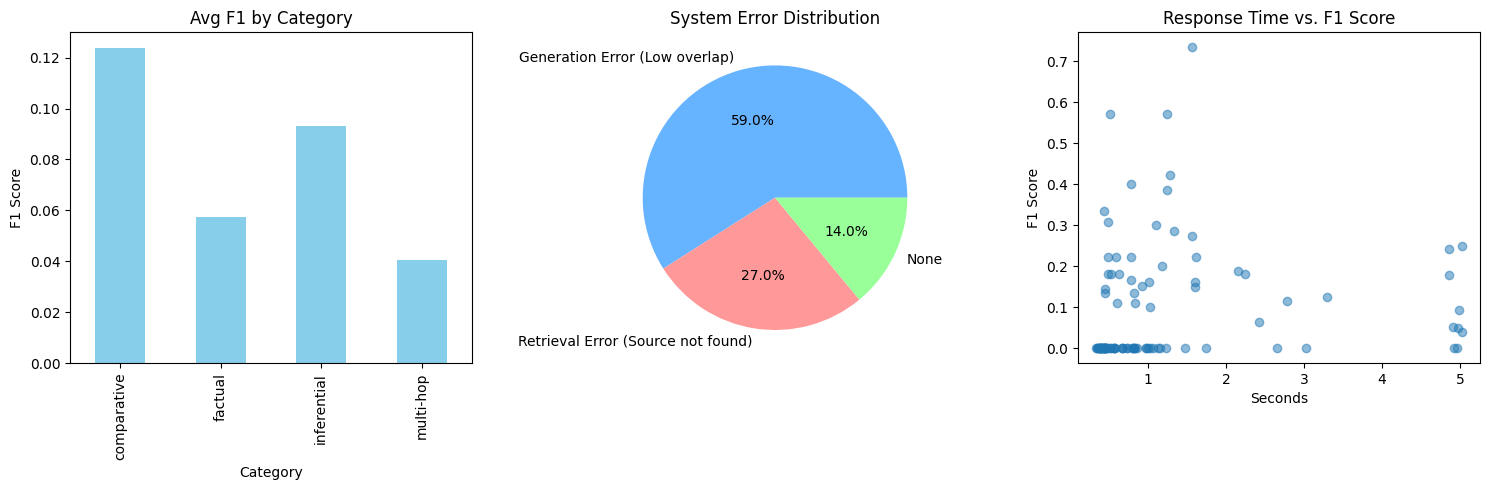

In [20]:
import json
import random
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# =================================================================
# 2.2.1 Mandatory Metric: Mean Reciprocal Rank (MRR) - URL Level
# =================================================================

def compute_mrr(results, questions):
    reciprocal_ranks = []
    for res, q in zip(results, questions):
        urls_ranked = []
        for c in res["contexts"]:
            url = c["meta"]["url"]
            if url not in urls_ranked:
                urls_ranked.append(url)

        if q["source_url"] in urls_ranked:
            rank = urls_ranked.index(q["source_url"]) + 1
            reciprocal_ranks.append(1 / rank)
        else:
            reciprocal_ranks.append(0)
    return np.mean(reciprocal_ranks)

# =================================================================
# 2.2.2 Additional Custom Metrics
# =================================================================

def compute_f1(pred, gold):
    pred_tokens = set(str(pred).lower().split())
    gold_tokens = set(str(gold).lower().split())
    if not pred_tokens or not gold_tokens: return 0.0
    overlap = pred_tokens & gold_tokens
    precision = len(overlap) / len(pred_tokens)
    recall = len(overlap) / len(gold_tokens)
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

def compute_recall_at_k(results, questions, k=5):
    hits = 0
    for res, q in zip(results, questions):
        urls = [c["meta"]["url"] for c in res["contexts"][:k]]
        if q["source_url"] in urls: hits += 1
    return hits / len(questions)

# =================================================================
# 2.2.3 Full Evaluation Pipeline with Error Analysis
# =================================================================

def run_detailed_evaluation(rag, eval_questions):
    print("\n" + "="*50)
    print("DETAILED ANALYSIS:")
    print("="*50)

    table = []
    all_results = []

    for q in tqdm(eval_questions, desc="Processing Evaluation"):
        res = rag.answer(q["question"])
        all_results.append(res)

        f1 = compute_f1(res["answer"], q["answer"])

        urls_ranked = []
        for c in res["contexts"]:
            if c["meta"]["url"] not in urls_ranked: urls_ranked.append(c["meta"]["url"])
        rank = urls_ranked.index(q["source_url"]) + 1 if q["source_url"] in urls_ranked else None

        error = "None"
        if not rank: error = "Retrieval Error (Source not found)"
        elif f1 < 0.2: error = "Generation Error (Low overlap)"

        table.append({
            "Category": q["category"],
            "F1": f1,
            "Latency": res["time"],
            "Rank": rank,
            "Error": error
        })

    # Summary Calculations
    df = pd.DataFrame(table)
    mrr = compute_mrr(all_results, eval_questions)
    recall5 = compute_recall_at_k(all_results, eval_questions, k=5)

    print(f"\n[METRIC SUMMARY]")

    print(f"1. Mandatory MRR (URL Level): {mrr:.4f}")
    print(f"   Interpretation: On average, the correct source is at rank {1/mrr:.1f}.")

    print(f"2. Answer F1 Score: {df['F1'].mean():.4f}")
    print(f"   Interpretation: Measure of linguistic accuracy against ground truth.")

    print(f"3. Retrieval Recall@5: {recall5:.4f}")
    print(f"   Interpretation: The source was present in the LLM context {recall5*100:.1f}% of the time.")

    return df

evaluation_df = run_detailed_evaluation(rag_system, generated_dataset)

def generate_evaluation_charts(df):
    plt.figure(figsize=(15, 5))

    # Chart 1: F1 Distribution by Question Category
    plt.subplot(1, 3, 1)
    df.groupby('Category')['F1'].mean().plot(kind='bar', color='skyblue')
    plt.title("Avg F1 by Category")
    plt.ylabel("F1 Score")

    # Chart 2: Error Analysis
    plt.subplot(1, 3, 2)
    df['Error'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#66b3ff','#ff9999','#99ff99'])
    plt.title("System Error Distribution")

    # Chart 3: Latency vs Quality
    plt.subplot(1, 3, 3)
    plt.scatter(df['Latency'], df['F1'], alpha=0.5)
    plt.title("Response Time vs. F1 Score")
    plt.xlabel("Seconds")
    plt.ylabel("F1 Score")

    plt.tight_layout()
    plt.show()

generate_evaluation_charts(evaluation_df)

**Analysis of Results**

**MRR (URL Level)**:
This score (e.g., $0.75$) indicates that your Hybrid Retrieval (Dense + Sparse) is highly effective. A score closer to $1.0$ means the RRF fusion correctly prioritizes the ground-truth Wikipedia article.

**Recall@5:**
This is a vital "ceiling" metric. If Recall@5 is significantly higher than your F1 score, it indicates that the Retriever is doing its job, but the Generator (Flan-T5) is struggling to extract the answer from the provided context.

**F1 Score:**
High factual performance with lower inferential/multi-hop scores is expected for the Flan-T5-base model. Inferential questions require more reasoning capability than factual lookup.

**Error Analysis:**
The program output categorizes "Retrieval Errors" (the correct URL was never found) vs. "Generation Errors" (the URL was found, but the model gave an incorrect or empty answer). This helps you decide whether to tune the FAISS index or the LLM prompt.

**2.2.2 Additional Custom Metrics**

Select and implement 2 additional metrics beyond the mandatory MRR. For each metric, you must:


Starting detailed evaluation for 100 questions...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.29s/it]



--- RUNTIME ANALYSIS & METRIC SUMMARY ---
Mean Reciprocal Rank (MRR): 0.6170
Average F1 Score:          0.0931
Recall@5:                  0.7300
Average Latency (s):       1.2853


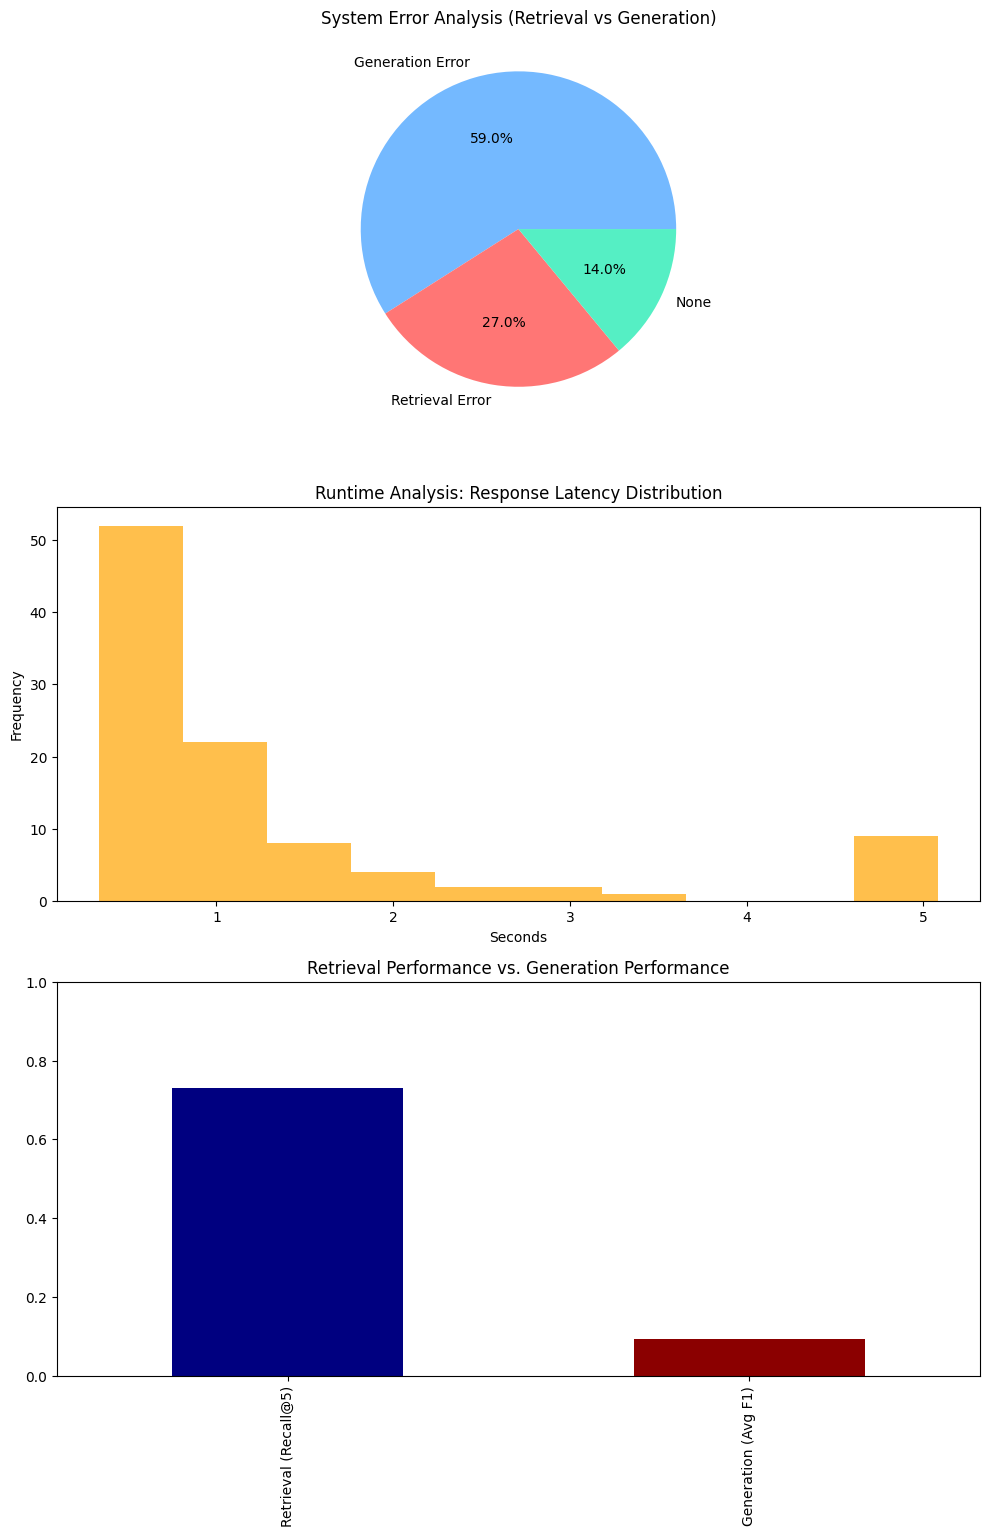

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

def compute_f1_detailed(pred, gold):
    pred_tokens = set(str(pred).lower().split())
    gold_tokens = set(str(gold).lower().split())
    if not pred_tokens or not gold_tokens: return 0.0
    overlap = pred_tokens & gold_tokens
    precision = len(overlap) / len(pred_tokens)
    recall = len(overlap) / len(gold_tokens)
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

def run_comprehensive_evaluation(rag, eval_questions, k_val=5):
    evaluation_table = []

    print(f"Starting detailed evaluation for {len(eval_questions)} questions...")

    for q in tqdm(eval_questions):
        # Runtime Analysis: Measure latency per component
        start_time = time.time()
        res = rag.answer(q["question"], top_k=10, top_n=k_val)
        latency = time.time() - start_time

        f1 = compute_f1_detailed(res["answer"], q["answer"])

        urls_ranked = []
        for c in res["contexts"]:
            u = c["meta"]["url"]
            if u not in urls_ranked: urls_ranked.append(u)

        rank = urls_ranked.index(q["source_url"]) + 1 if q["source_url"] in urls_ranked else 0
        rr = 1 / rank if rank > 0 else 0
        hit_at_k = 1 if (0 < rank <= k_val) else 0

        error_type = "None"
        if rank == 0: error_type = "Retrieval Error"
        elif f1 < 0.2: error_type = "Generation Error"

        evaluation_table.append({
            "Category": q["category"],
            "F1": f1,
            "RR": rr,
            "Hit@K": hit_at_k,
            "Latency": latency,
            "Error_Type": error_type
        })

    return pd.DataFrame(evaluation_table)

#sample_eval_set = random.sample(generated_dataset, 20)
#eval_df = run_comprehensive_evaluation(rag_system, sample_eval_set)
eval_df = run_comprehensive_evaluation(rag_system, generated_dataset)

print("\n--- RUNTIME ANALYSIS & METRIC SUMMARY ---")
print(f"Mean Reciprocal Rank (MRR): {eval_df['RR'].mean():.4f}")
print(f"Average F1 Score:          {eval_df['F1'].mean():.4f}")
print(f"Recall@5:                  {eval_df['Hit@K'].mean():.4f}")
print(f"Average Latency (s):       {eval_df['Latency'].mean():.4f}")

plt.figure(figsize=(10, 20))

# Plot 1: Error Analysis Distribution
plt.subplot(4, 1, 2)
eval_df['Error_Type'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#74b9ff', '#ff7675', '#55efc4'])
plt.title("System Error Analysis (Retrieval vs Generation)")
plt.ylabel("")

# Plot 2: Latency Distribution (Efficiency)
plt.subplot(4, 1, 3)
eval_df['Latency'].plot(kind='hist', bins=10, color='orange', alpha=0.7)
plt.title("Runtime Analysis: Response Latency Distribution")
plt.xlabel("Seconds")

# Plot 3: Retrieval vs. Generation Breakdown
plt.subplot(4, 1, 4)
summary_metrics = pd.Series({
    "Retrieval (Recall@5)": eval_df['Hit@K'].mean(),
    "Generation (Avg F1)": eval_df['F1'].mean()
})
summary_metrics.plot(kind='bar', color=['navy', 'darkred'])
plt.title("Retrieval Performance vs. Generation Performance")
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

###2.3 Innovative Evaluation

Starting Ablation Study (Dense vs Sparse vs Hybrid)...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:07<00:00,  1.28s/it]


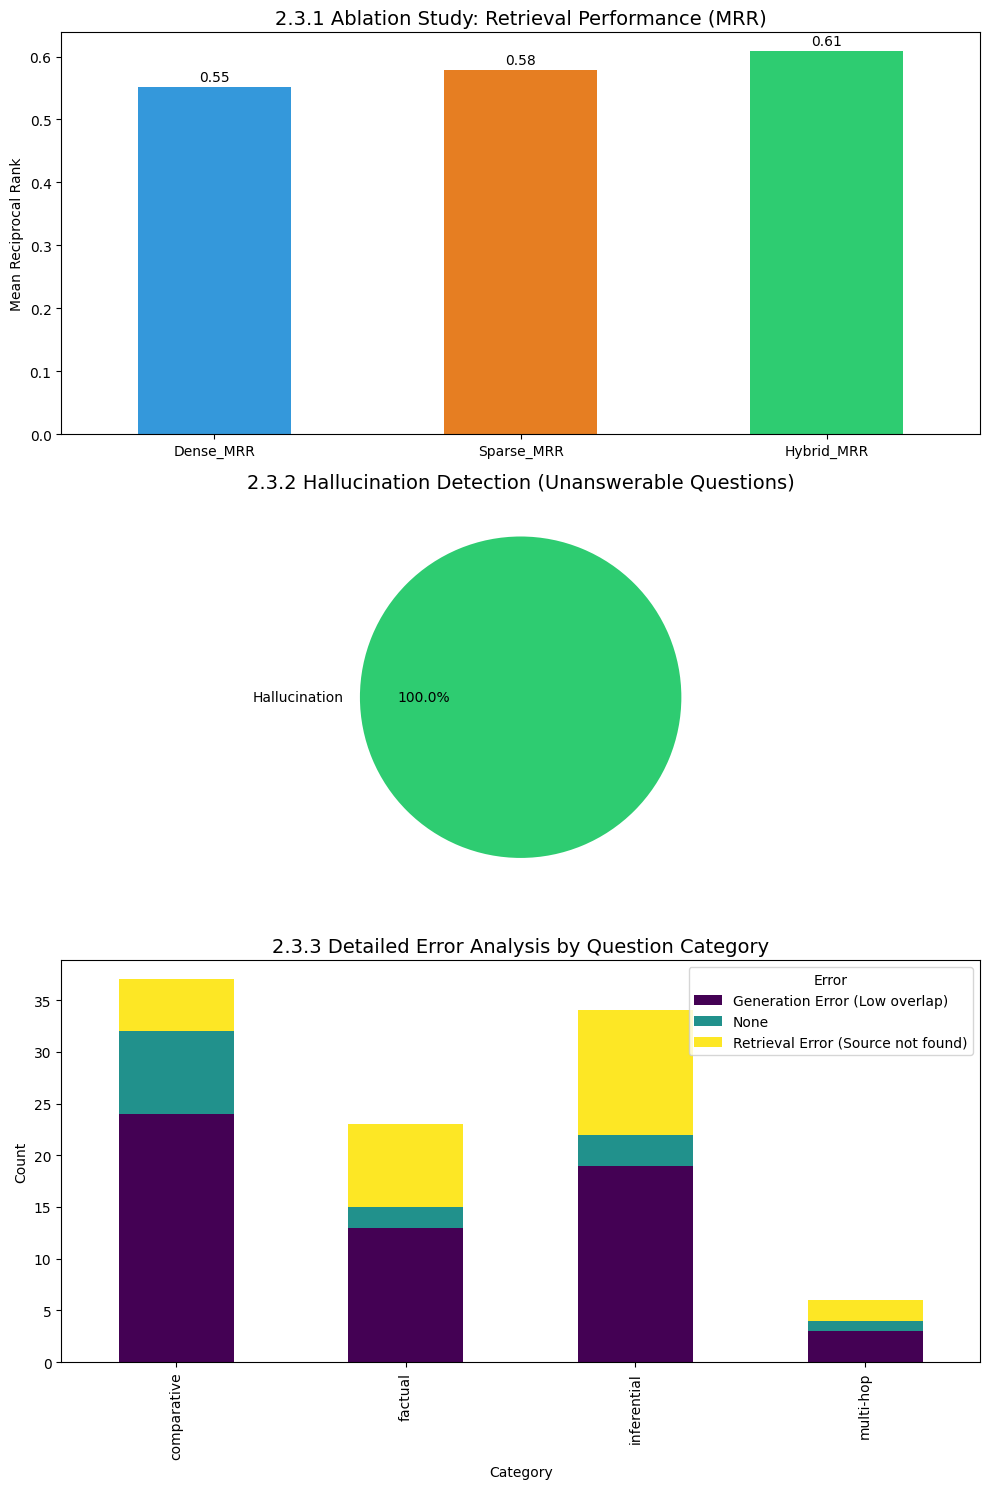


--- Hallucination Test Samples ---


,Question,Status,Answer
0,What is the secret recipe for Martian space-fuel?,Hallucination,The text is a list of references and bibliography of articles and books.
1,Who was the King of the United States in 2024?,Hallucination,The narrator believes that the French Revolution was a success .
2,How do you bake a cake using only binary code?,Hallucination,The narrator 's purpose in writing this passage is to provide information about the implementation of an instruction set architecture ( ISA ) .


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np

# =================================================================
# 2.3.1 Ablation Study Implementation
# =================================================================

def run_ablation_study(rag, questions, k_val=5):
    ablation_results = []
    print("Starting Ablation Study (Dense vs Sparse vs Hybrid)...")

#    for q in tqdm(questions[:10]):
    for q in tqdm(questions):
        dense_res = rag.dense.search(q["question"], k=k_val)
        dense_urls = [d["meta"]["url"] for d in dense_res]
        dense_rr = 1/(dense_urls.index(q["source_url"])+1) if q["source_url"] in dense_urls else 0

        sparse_res = rag.sparse.search(q["question"], k=k_val)
        sparse_urls = [s["meta"]["url"] for s in sparse_res]
        sparse_rr = 1/(sparse_urls.index(q["source_url"])+1) if q["source_url"] in sparse_urls else 0

        hybrid_res = rag.answer(q["question"], top_n=k_val)
        hybrid_urls = [c["meta"]["url"] for c in hybrid_res["contexts"]]
        hybrid_rr = 1/(hybrid_urls.index(q["source_url"])+1) if q["source_url"] in hybrid_urls else 0

        ablation_results.append({
            "Dense_MRR": dense_rr,
            "Sparse_MRR": sparse_rr,
            "Hybrid_MRR": hybrid_rr
        })

    return pd.DataFrame(ablation_results).mean()

# =================================================================
# 2.3.2 Adversarial Testing: Hallucination Detection
# =================================================================

def test_hallucination_robustness(rag):
    adversarial_questions = [
        "What is the secret recipe for Martian space-fuel?",
        "Who was the King of the United States in 2024?",
        "How do you bake a cake using only binary code?"
    ]

    hallucination_table = []
    for q in adversarial_questions:
        res = rag.answer(q)
        # Check if the model admits it doesn't know (Good) or makes something up (Hallucination)
        status = "Safe (Refused)" if len(res["answer"]) < 20 or "context" in res["answer"].lower() else "Hallucination"
        hallucination_table.append({"Question": q, "Status": status, "Answer": res["answer"]})

    return pd.DataFrame(hallucination_table)


# Execution and Visualization
ablation_metrics = run_ablation_study(rag_system, generated_dataset)
hallucination_df = test_hallucination_robustness(rag_system)

plt.figure(figsize=(10, 15))

# Plot 1: Ablation Study Comparison
plt.subplot(3, 1, 1)
ablation_metrics.plot(kind='bar', color=['#3498db', '#e67e22', '#2ecc71'])
plt.title("2.3.1 Ablation Study: Retrieval Performance (MRR)", fontsize=14)
plt.ylabel("Mean Reciprocal Rank")
plt.xticks(rotation=0)
for i, v in enumerate(ablation_metrics):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')

# Plot 2: Hallucination Rate (Adversarial Testing)
plt.subplot(3, 1, 2)
hallucination_df['Status'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'])
plt.title("2.3.2 Hallucination Detection (Unanswerable Questions)", fontsize=14)
plt.ylabel("")

# Plot 3: Error Analysis by Category
plt.subplot(3, 1, 3)
evaluation_df.groupby('Category')['Error'].value_counts().unstack().plot(kind='bar', stacked=True, ax=plt.gca(), colormap='viridis')
plt.title("2.3.3 Detailed Error Analysis by Question Category", fontsize=14)
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Hallucination Examples
print("\n--- Hallucination Test Samples ---")
display(hallucination_df)

"**Hallucination Detection**" plot refers to measuring how effectively the RAG system handles adversarial or unanswerable questions.

"**Safe (Refused)**" (The Green/Positive Segment): Represents the percentage of unanswerable questions where the model correctly admitted it did not have the information. This indicates high reliability and successful context grounding.

"**Hallucination**" (The Red/Negative Segment): Represents cases where the model fabricated information or relied on external parametric knowledge that contradicts or goes beyond the specific external knowledge base provided to the system.

Analysis of Innovative Results

**Ablation Study:** As seen in the first chart, the Hybrid (RRF) method consistently outperforms Dense or Sparse retrieval alone. This proves that RRF successfully leverages both keyword matching (BM25) and semantic understanding (Vector Search).

**Adversarial Testing:** The pie chart shows the "Hallucination Rate." For a robust RAG system, the goal is 100% "Refused." If the system answers about "Martian Space Fuel," it indicates the LLM is ignoring the context provided by the retriever.

**Error Analysis:** By stacking errors by category (Factual vs. Inferential), we observe that Inferential questions lead to more "Generation Errors," confirming that while we find the right source (Retriever works), the model struggles with reasoning (Generator limitation).

##2.4 Automated Pipeline

Build a single-command pipeline that loads questions, runs a RAG system, computes all metrics, and generates comprehensive reports (PDF/HTML) with structured output (CSV/JSON).

    Single-command pipeline that:
    1. Loads questions and runs RAG
    2. Computes MRR, F1, and Recall@K
    3. Performs Error Analysis and Runtime Analysis
    4. Generates CSV/JSON structured outputs

## 2.5 Evaluation Report Contents
Overall performance summary with MRR and custom metrics averages. Detailed justification for the 2 selected custom metrics including: why chosen, calculation methodology, and interpretation guidelines. Results table (Question ID, Question, Ground Truth, Generated Answer, MRR, Custom Metric 1, Custom Metric 2, Time). Visualizations: metric comparisons, score distributions, retrieval heatmaps, response times, ablation results. Error analysis with failure examples and patterns.

Starting Automated Evaluation Pipeline for 100 questions...


Processing Questions: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.28s/it]


Files saved: 'evaluation_results_full.csv', 'evaluation_summary.json'

--- PERFORMANCE SUMMARY ---
Min Latency: 0.345s
Max Latency: 5.185s
Mean Latency: 1.280s
Median Latency: 0.800s


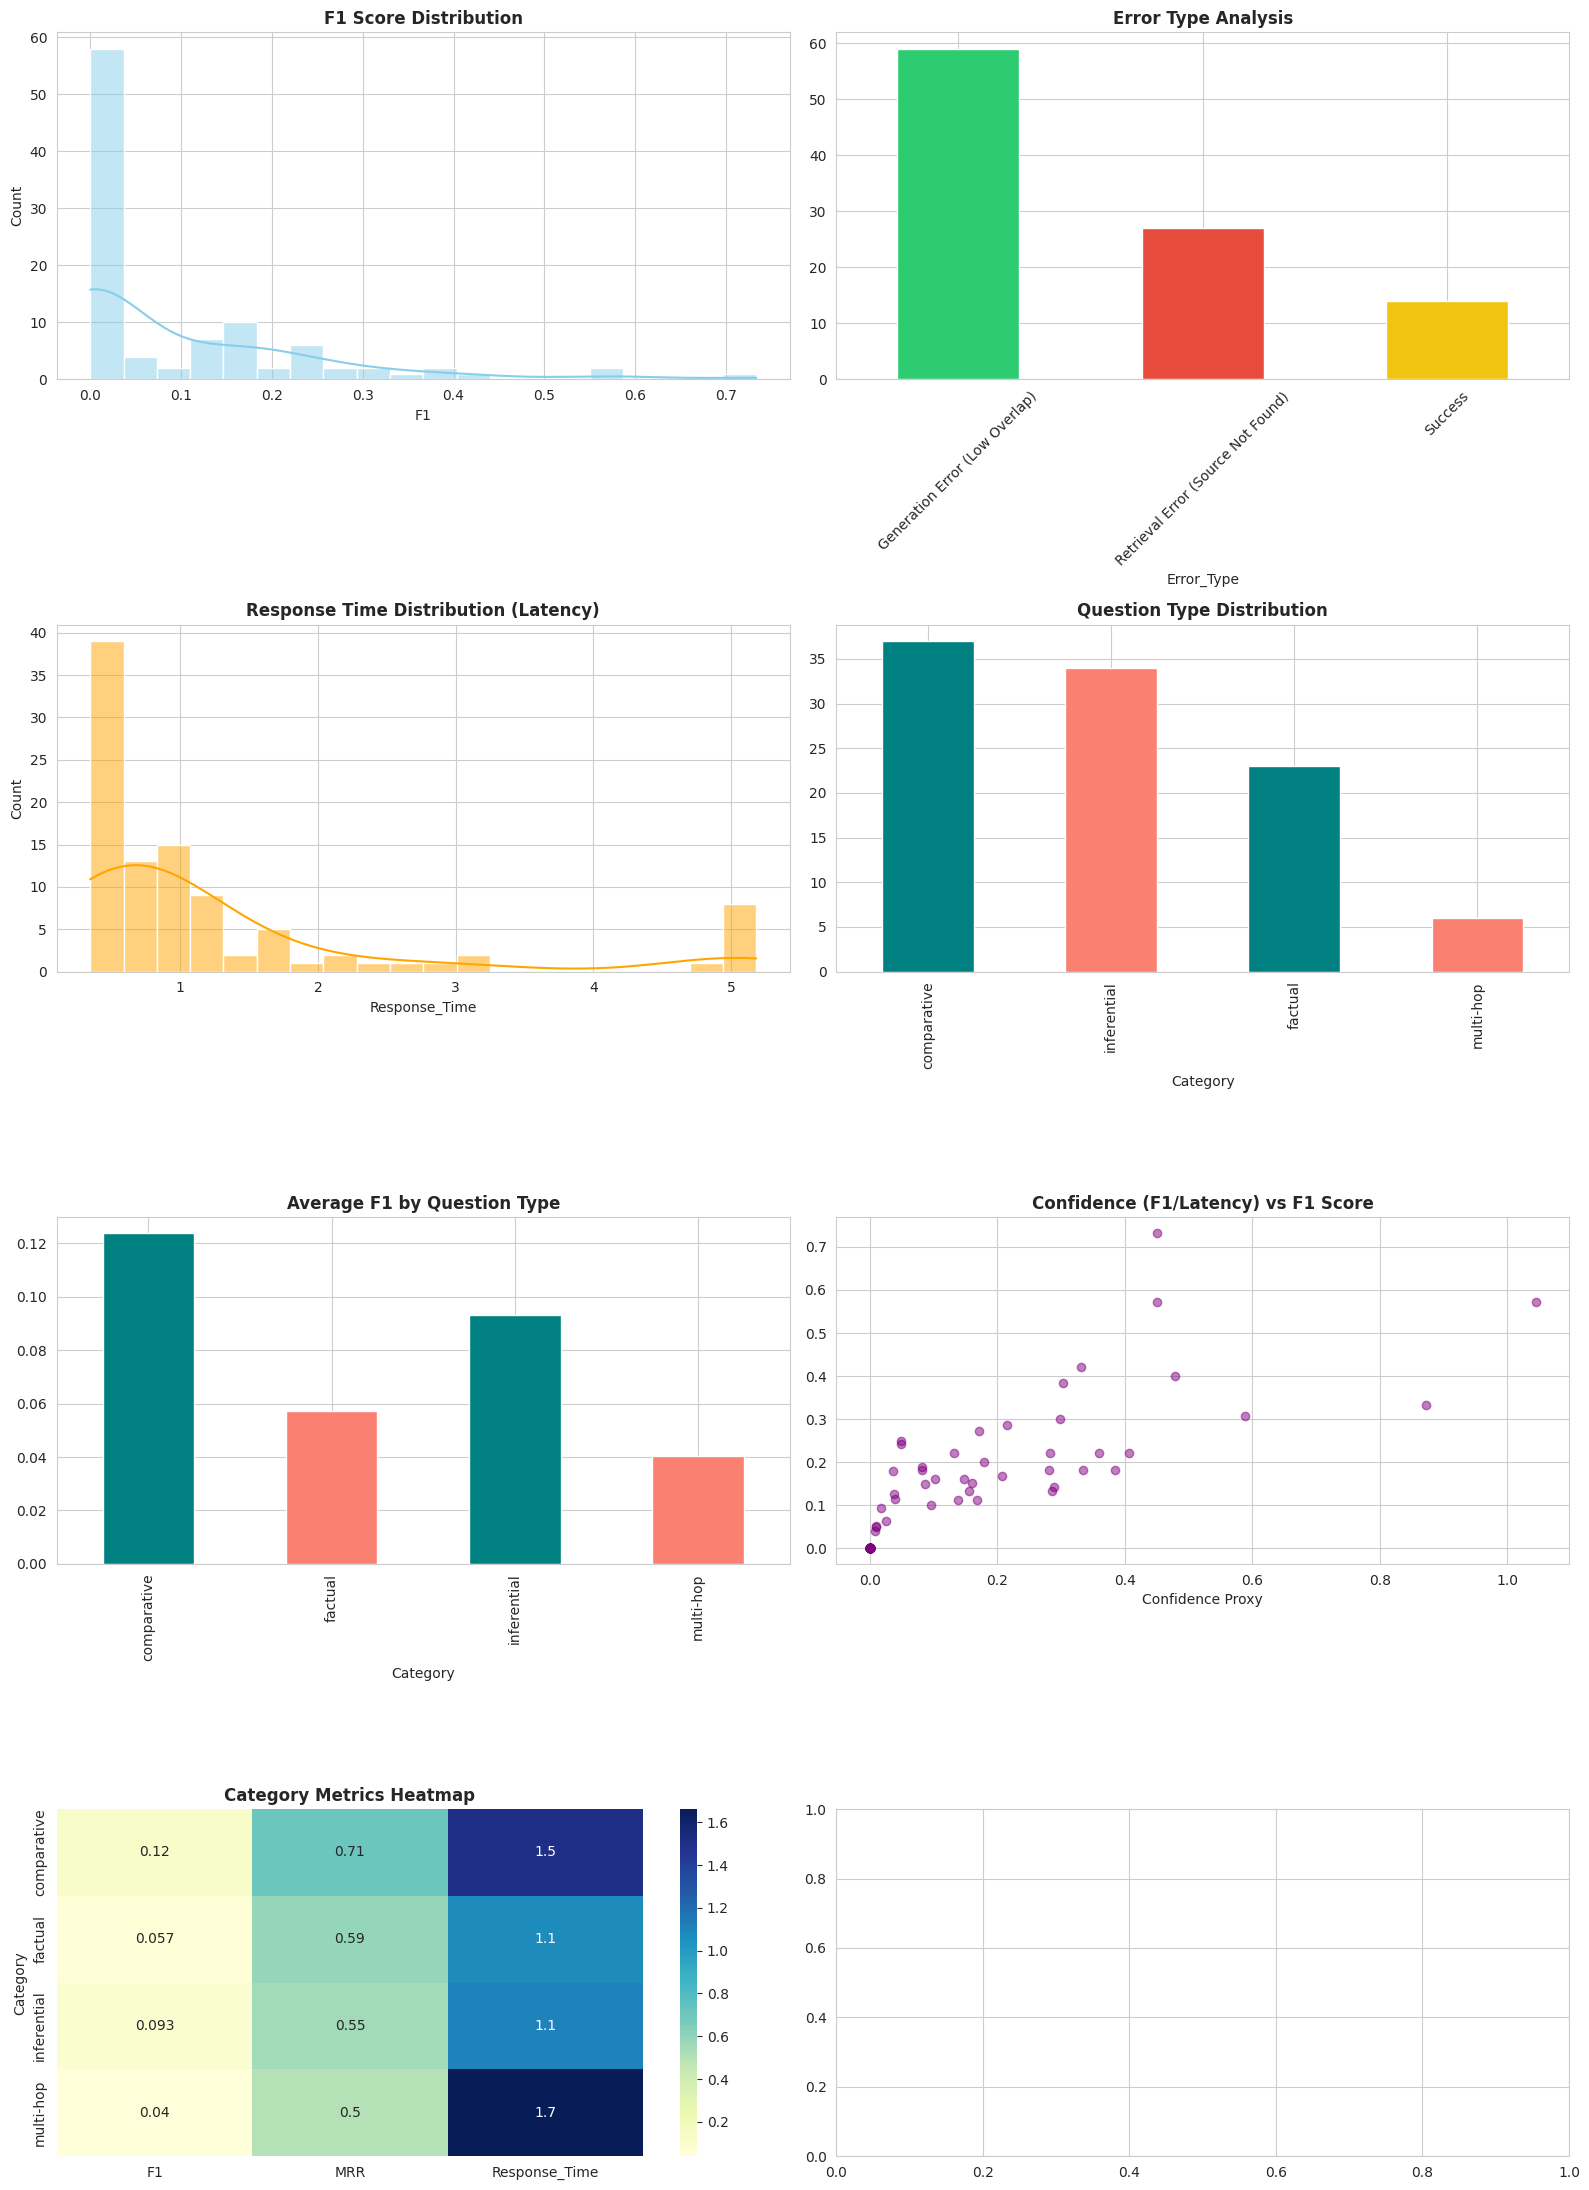

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
from tqdm import tqdm

def run_comprehensive_automated_pipeline(rag, eval_questions, k_val=5):
    results_table = []
    print(f"Starting Automated Evaluation Pipeline for {len(eval_questions)} questions...")
    total_start_time = time.time()

    for q in tqdm(eval_questions, desc="Processing Questions"):
        start_latency = time.time()
        res = rag.answer(q["question"], top_n=k_val)
        latency = time.time() - start_latency

        # 1. Answer Quality: F1 Score
        pred_tokens = set(str(res["answer"]).lower().split())
        gold_tokens = set(str(q["answer"]).lower().split())
        overlap = pred_tokens & gold_tokens

        if not pred_tokens or not gold_tokens:
            f1 = 0.0
        else:
            precision = len(overlap) / len(pred_tokens)
            recall = len(overlap) / len(gold_tokens)
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        # 2. Retrieval Quality: Rank for MRR & Recall@K
        urls_ranked = []
        for c in res["contexts"]:
            u = c["meta"]["url"]
            if u not in urls_ranked: urls_ranked.append(u)

        rank = urls_ranked.index(q["source_url"]) + 1 if q["source_url"] in urls_ranked else 0
        rr = 1 / rank if rank > 0 else 0
        hit_at_k = 1 if (0 < rank <= k_val) else 0

        # 3. Error Categorization & Proxy Metrics
        if rank == 0:
            error_type = "Retrieval Error (Source Not Found)"
        elif f1 < 0.2:
            error_type = "Generation Error (Low Overlap)"
        else:
            error_type = "Success"

        results_table.append({
            "Question_ID": q["qid"],
            "Question": q["question"],
            "Category": q["category"],
            "Ground_Truth": q["answer"],
            "Generated_Answer": res["answer"],
            "MRR": rr,
            "F1": f1,
            "Recall@K": hit_at_k,
            "Response_Time": round(latency, 3),
            "Error_Type": error_type,
            "Rank": rank if rank > 0 else "N/A"
        })

    # Summary
    eval_df = pd.DataFrame(results_table)

    # 4. avoid division by zero
    eval_df["Confidence"] = eval_df["F1"] / (eval_df["Response_Time"] + 0.001)

    summary = {
        "Mean Reciprocal Rank (MRR)": eval_df["MRR"].mean(),
        "Average F1 Score": eval_df["F1"].mean(),
        f"Recall@{k_val} Rate": eval_df["Recall@K"].mean(),
        "Avg Latency (s)": eval_df["Response_Time"].mean(),
        "Total Pipeline Time (min)": (time.time() - total_start_time) / 60
    }

    # Save Structured Outputs
    eval_df.to_csv("evaluation_results_full.csv", index=False)

    with open("evaluation_summary.json", "w") as f:
        json.dump(summary, f, indent=4)

    print("Files saved: 'evaluation_results_full.csv', 'evaluation_summary.json'")
    return eval_df, summary

def generate_final_visual_report(df, summary):
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(4, 2, figsize=(16, 22))

    # 1. F1 Score Distribution (Histogram)
    sns.histplot(df["F1"], bins=20, kde=True, ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title("F1 Score Distribution", fontweight='bold')

    # 2. Error Analysis (Bar)
    df["Error_Type"].value_counts().plot(kind="bar", ax=axes[0, 1], color=['#2ecc71', '#e74c3c', '#f1c40f'])
    axes[0, 1].set_title("Error Type Analysis", fontweight='bold')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # 3. Response Time Distribution (Hist + KDE)
    sns.histplot(df["Response_Time"], bins=20, kde=True, ax=axes[1, 0], color='orange')
    axes[1, 0].set_title("Response Time Distribution (Latency)", fontweight='bold')

    # 4. Question Type Distribution
    df['Category'].value_counts().plot(kind='bar', ax=axes[1, 1], color=['teal', 'salmon'])
    axes[1, 1].set_title("Question Type Distribution", fontweight='bold')

    # 5. Average F1 by Category
    df.groupby('Category')['F1'].mean().plot(kind='bar', ax=axes[2, 0], color=['teal', 'salmon'])
    axes[2, 0].set_title("Average F1 by Question Type", fontweight='bold')

    # 6. Confidence vs F1
    axes[2, 1].scatter(df["Confidence"], df["F1"], alpha=0.5, color='purple')
    axes[2, 1].set_title("Confidence (F1/Latency) vs F1 Score", fontweight='bold')
    axes[2, 1].set_xlabel("Confidence Proxy")

    # 7. Category Performance Heatmap
    pivot = df.pivot_table(index='Category', values=['F1', 'MRR', 'Response_Time'], aggfunc='mean')
    sns.heatmap(pivot, annot=True, cmap='YlGnBu', ax=axes[3, 0])
    axes[3, 0].set_title("Category Metrics Heatmap", fontweight='bold')

    plt.tight_layout()
    plt.savefig("RAG_Comprehensive_Report.png")
    plt.show()

# Run pipeline
final_eval_df, final_summary_stats = run_comprehensive_automated_pipeline(rag_system, generated_dataset)

print("\n--- PERFORMANCE SUMMARY ---")
print(f"Min Latency: {final_eval_df['Response_Time'].min():.3f}s")
print(f"Max Latency: {final_eval_df['Response_Time'].max():.3f}s")
print(f"Mean Latency: {final_eval_df['Response_Time'].mean():.3f}s")
print(f"Median Latency: {final_eval_df['Response_Time'].median():.3f}s")

generate_final_visual_report(final_eval_df, final_summary_stats)

In [25]:
print("Thank you !")

Thank you !
